## **Programming for Data Analysis Assignment 2**

**Rachel King**

***

## **Table of Contents**

## **Introduction**

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import sys
from sklearn.impute import SimpleImputer
import random
from plotly.offline import iplot
from plotnine import ggplot, aes, geom_line, geom_bar, geom_point, labs, coord_flip, theme_xkcd, geom_smooth
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## **Temperature and CO2**

In [2]:
epica = pd.read_csv('CSV Files\Epica Temp.csv', encoding='ISO-8859-1')
ipcc = pd.read_csv('CSV Files\IPCC CO2.csv')
nature = pd.read_csv('CSV Files/Nature CO2.csv', dtype={'year': int})

In [3]:
epica.year = epica.year.round()
ipcc["year"] = pd.to_numeric(ipcc["year"])
ipcc.year = ipcc.year.round()

epica = epica[['year', 'temp']]
ipcc = ipcc[['year', 'co2']]
nature = nature[['year', 'co2']]

In [4]:
nature["year"] = pd.to_numeric(nature["year"])
nature.year = nature.year.round()

In [5]:
epica['year'] = 1950 - epica['year']
ipcc['year'] = 1950 - ipcc['year']
nature['year'] = 1950 - nature['year']

In [6]:
combined_CO2 = pd.concat([ipcc, nature])
combined_CO2.sort_values(by=['year'], ascending=True)

temp_CO2 = pd.concat([epica.dropna(), combined_CO2.dropna()], ignore_index=True)
temp_CO2.sort_values(by=['year'], ascending=True);

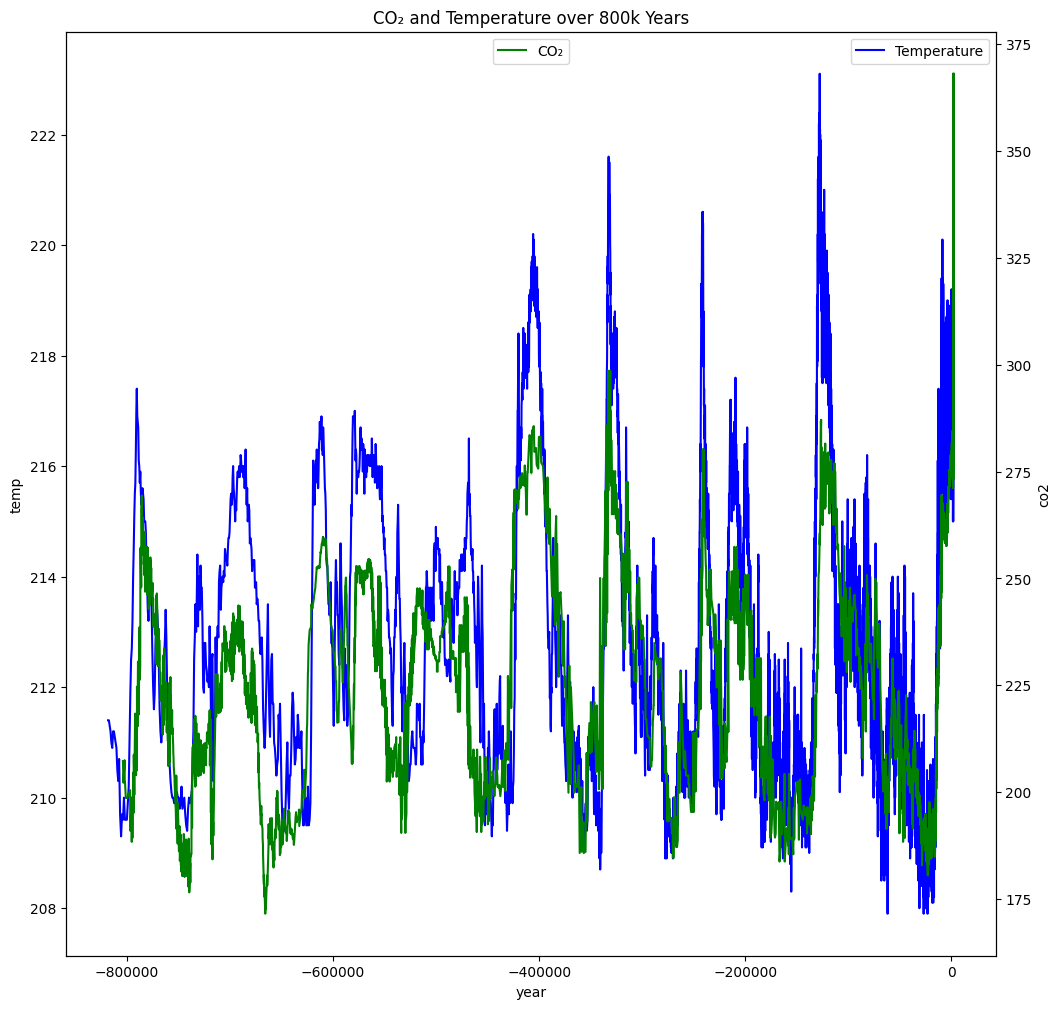

In [7]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp", data=temp_CO2, color="b", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2, color="g", ax=ax2, label="CO₂")
plt.title("CO₂ and Temperature over 800k Years")
plt.legend(loc='upper center')

In [8]:
temp_present = pd.read_csv('CSV Files/temp 1958 to present.csv', encoding='ISO-8859-1', dtype={'year': int})
temp_present = temp_present[['year', 'temp']]

combined_temp = pd.concat([epica, temp_present])
combined_temp.sort_values(by=['year'], inplace=True, ascending=True);
combined_temp = combined_temp.astype({'year':'int'})

In [9]:
co2_present = pd.read_csv('CSV Files\co2_annmean_mlo.csv', encoding='ISO-8859-1', dtype={'year': int})
co2_present = co2_present[['year', 'co2']]

total_combined_co2 = pd.concat([combined_CO2, co2_present])
total_combined_co2.sort_values(by=['year'], inplace=True, ascending=True);
total_combined_co2 = total_combined_co2.astype({'year':'int'})

In [10]:
temp_CO2_present = combined_temp.merge(total_combined_co2, on='year', how='outer')
temp_CO2_present.sort_values(by=['year'], inplace=True, ascending=True);
temp_CO2_present = temp_CO2_present.astype({'year':'int'})

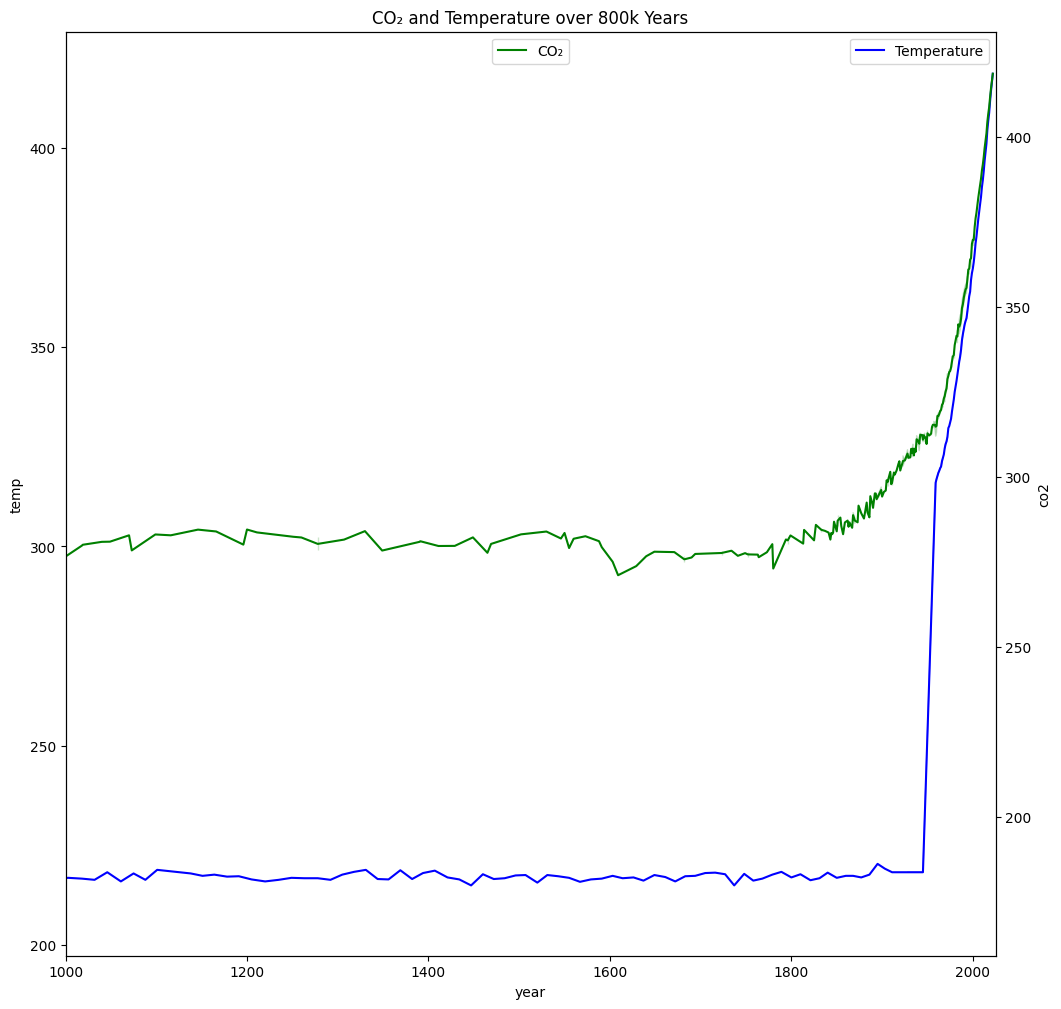

In [11]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="g", ax=ax2, label="CO₂")
ax1.set_xlim(1000, 2025)
ax2.set_xlim(1000, 2025)
plt.title("CO₂ and Temperature over 800k Years")
plt.legend(loc='upper center')

## **Sea Ice**

In [12]:
sea_ice = pd.read_csv('CSV Files\seaice.csv')

In [13]:
# We only take data from the northern hemisphere
northern = sea_ice[sea_ice.iloc[:,6]=='north']

In [14]:
# Save the list of the years
years_list = list(northern['Year'].value_counts().index)
years_list = sorted(years_list)

In [15]:
import warnings
warnings.simplefilter(action='ignore')
# Calcule monthly average of sea ice extent
def by_months(northern):    
    n_months = 3 + ((2019-1979) * 12) + 5 
    sea_ice_monthly = pd.DataFrame(columns=['Year', 'Month', 'Extent'], index=range(n_months))
    i = 0
    for year in years_list:
        
        if year == 1978:
            months_list = range(10,13)
        elif year == 2019:
            months_list = range(1,6)
        else:
            months_list = range(1,13)

        for month in months_list:
            subset = northern[northern['Year']==year][northern.iloc[:,1]==month]
            monthly_mean = np.mean(subset.iloc[:,3])
            sea_ice_monthly.iloc[i] = [year, month, monthly_mean]
            i += 1

    return sea_ice_monthly

sea_ice_clean = by_months(northern)

In [16]:
sea_ice_clean.head()

,Year,Month,Extent
0,1978,10,10.402667
1,1978,11,11.645133
2,1978,12,13.667063
3,1979,1,15.414
4,1979,2,16.175286


In [17]:
# Sort the dataset per month and year
sea_ice_clean = sea_ice_clean.sort_values(['Month', 'Year'])
sea_ice_clean = sea_ice_clean.reset_index().drop(['index'], axis=1)
sea_ice_clean.head()

,Year,Month,Extent
0,1979,1,15.414
1,1980,1,14.861875
2,1981,1,14.909688
3,1982,1,15.176733
4,1983,1,14.942438


In [18]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = sea_ice_clean[sea_ice_clean.Month == m]['Extent'].mean()
  std = sea_ice_clean[sea_ice_clean.Month == m]['Extent'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std

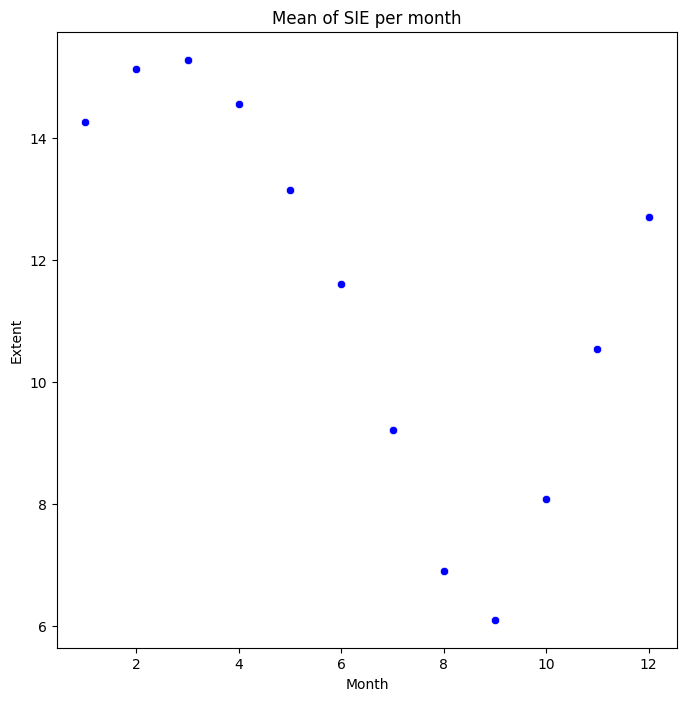

In [19]:
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Extent', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Extent', data=df_mean_years,  color='blue', sizes=20).set(title='Mean of SIE per month')
plt.show()

In [20]:
#Compute Sea Ice Extent anomalies
def anomaliesSIE(sea_ice):
  #Calcule mean by months from 1981-2010
  df_30y = sea_ice.query('1981 <= Year <= 2010')
  df_30y = df_30y.reset_index().drop(['index'], axis=1)
  mean_30y = []
  for m in range(1,13):
    mu = sea_ice[sea_ice.Month == m]['Extent'].mean()
    mean_30y.append(mu)

  #Compute SIE anomalies
  anomalies_list = []
  for s in range(0, len(sea_ice)):
    mean_30y_index = sea_ice.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_SIE = sea_ice.loc[s, 'Extent'] - mean_30y[mean_30y_index]
    anomalies_SIE = anomalies_SIE/mean_30y[mean_30y_index]*100
    #Save anomalies
    anomalies_list.append(anomalies_SIE)
  sea_ice['AnomaliesSIE'] = anomalies_list
  return sea_ice, mean_30y

df_SIE, mean_30y = anomaliesSIE(sea_ice_clean)

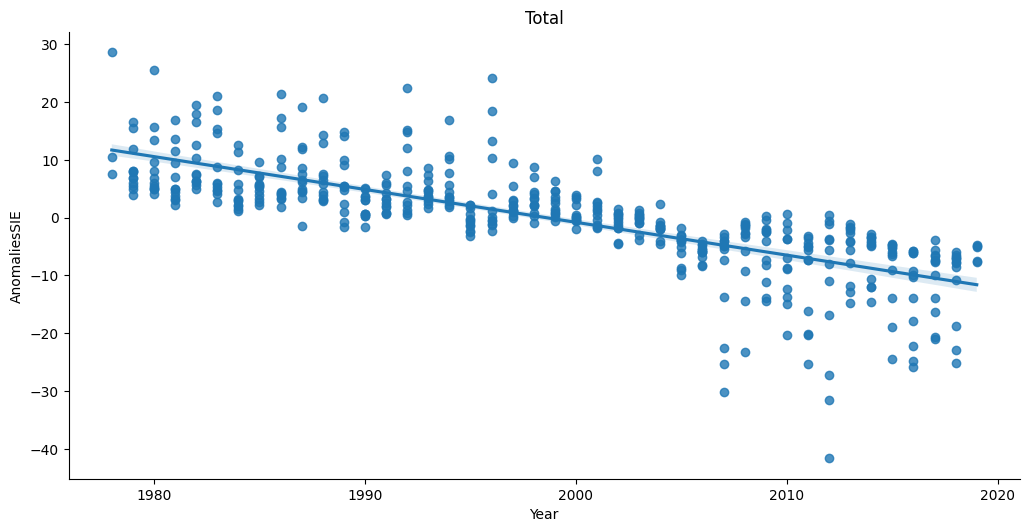

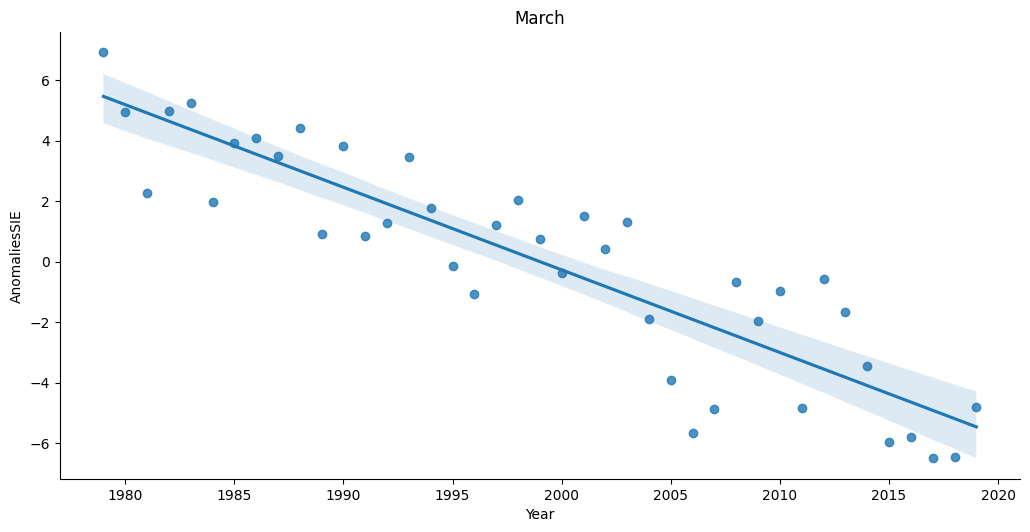

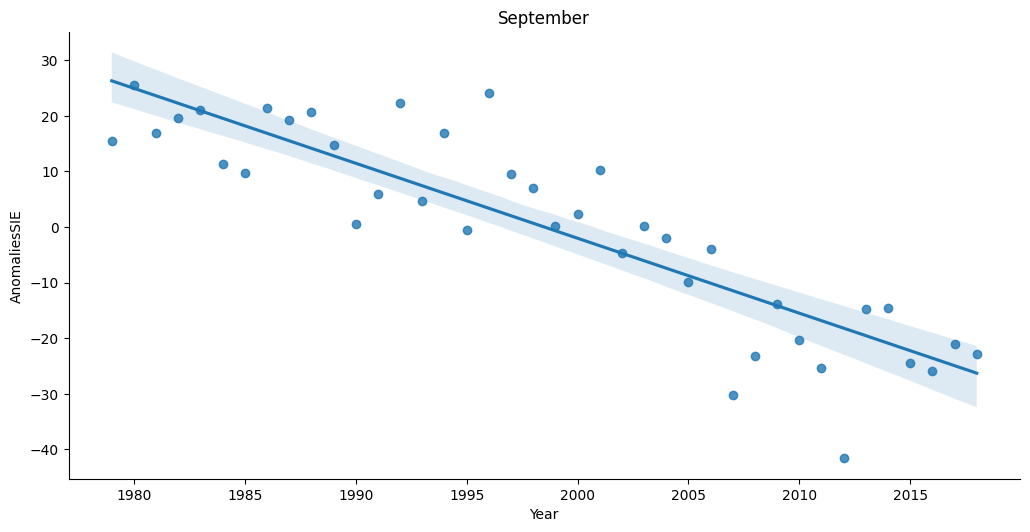

In [21]:
df_SIE['Year'] = pd.to_numeric(df_SIE['Year'])
#Total
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE, height=5.2, aspect=2).set(title='Total')
plt.show()
#January
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 3], height=5.2, aspect=2).set(title='March')
plt.show()
#June
sns.lmplot(x='Year', y='AnomaliesSIE', data=df_SIE[df_SIE.Month == 9], height=5.2, aspect=2).set(title='September')
plt.show()

In [22]:
seaice_mean = []
std_dict = {}
for y in range(1978, 2019):
  #Calcule mu and std values
  mu = sea_ice_clean[sea_ice_clean.Year == y]['Extent'].mean()
  std = sea_ice_clean[sea_ice_clean.Year == y]['Extent'].std()
  #Save mu and std values
  seaice_mean.append(mu)
  std_dict[y] = std

seaice_mean;

In [23]:
years_seaice = list(range(1978, 2019));

df_seaice_mean = pd.DataFrame({'year': years_seaice, 'sea_ice': seaice_mean})
df_seaice_mean.sea_ice = df_seaice_mean.sea_ice.round(2)
#df_seaice_mean.to_csv("df_seaice_mean.csv", encoding='utf-8', index=False)

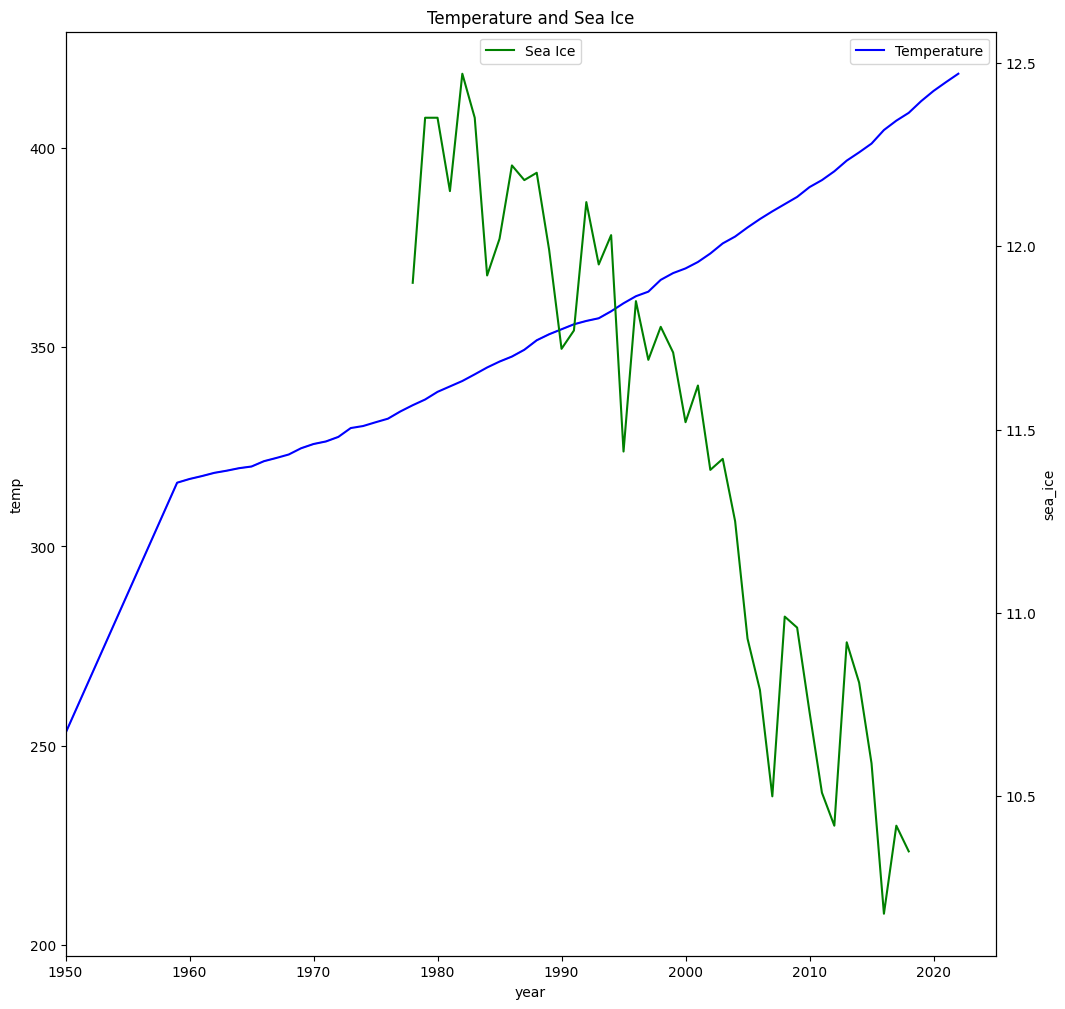

In [24]:
# to plot temperature vs sea ice
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice")
ax1.set_xlim(1950, 2025)
ax2.set_xlim(1950, 2025)
plt.title("Temperature and Sea Ice")
plt.legend(loc='upper center')

In [25]:
temp_CO2_from_1960 = temp_CO2_present[temp_CO2_present['year'] >= 1960]
temp_CO2_from_1960 = temp_CO2_from_1960.sort_values('temp', ascending=False).drop_duplicates('year').sort_index()

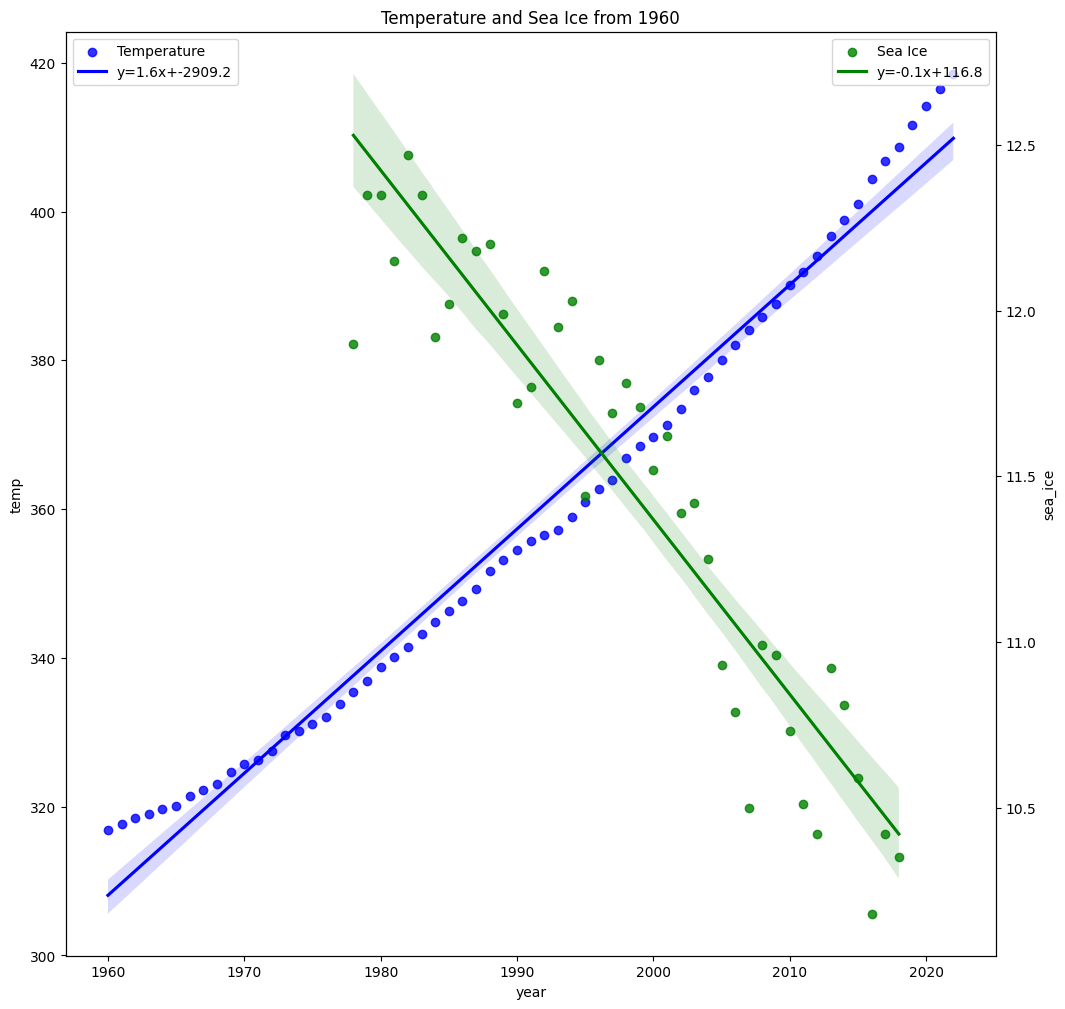

In [26]:
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(temp_CO2_from_1960['year'],temp_CO2_from_1960['temp'])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_seaice_mean['year'],df_seaice_mean['sea_ice'])

# to plot a regression plot of Temperature and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.regplot(x="year", y="temp", data=temp_CO2_from_1960, color="b", ax=ax1, label="Temperature", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
sns.regplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1)})
plt.title("Temperature and Sea Ice from 1960")
ax1.legend()
ax2.legend()

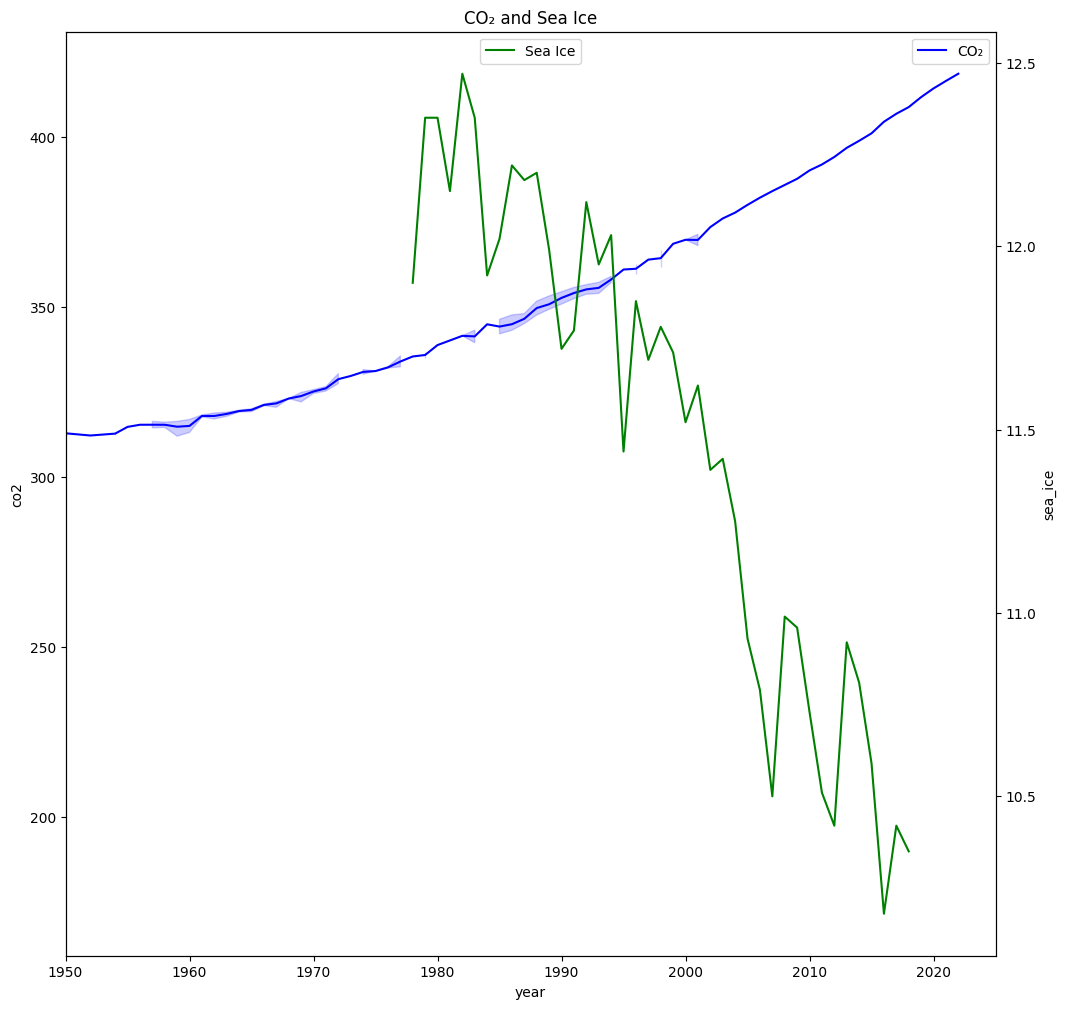

In [27]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="b", ax=ax1, label="CO₂")
sns.lineplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice")
ax1.set_xlim(1950, 2025)
ax2.set_xlim(1950, 2025)
plt.title("CO₂ and Sea Ice")
plt.legend(loc='upper center')

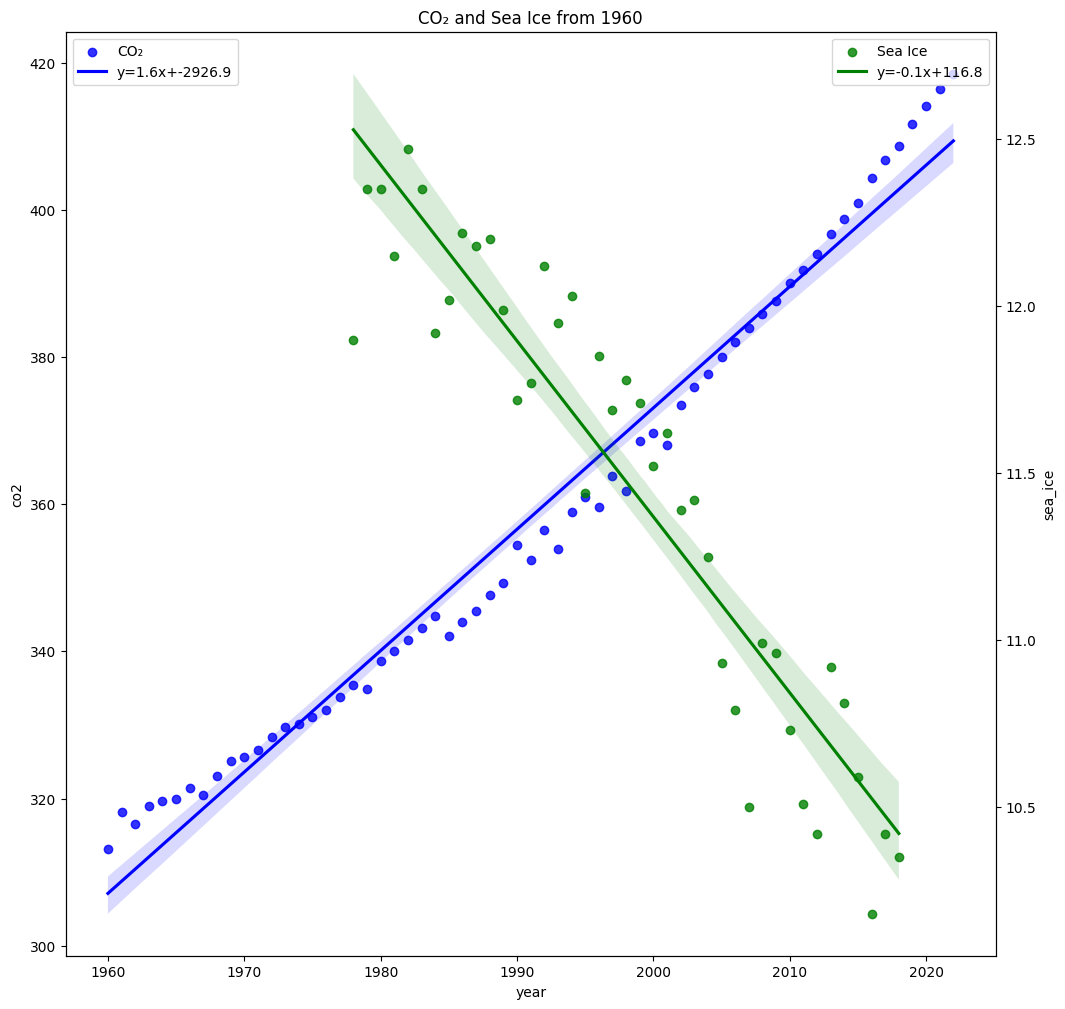

In [28]:
# get coeffs of linear fit
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(temp_CO2_from_1960['year'],temp_CO2_from_1960['co2'])

# to plot a regression plot of CO₂ and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.regplot(x="year", y="co2", data=temp_CO2_from_1960, color="b", ax=ax1, label="CO₂", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope2,intercept2)})
sns.regplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1)})
plt.title("CO₂ and Sea Ice from 1960")
ax1.legend()
ax2.legend()

A linear regression equation was calculated for the temperature, CO₂ and sea ice data from 1960 to 2020. 

- The temperature and CO₂ data had a slope (m) of 1.6. This indicates the rate of change of y (temp or CO₂) is changing positively (increasing) as x (years) changes.
- The sea ice data had a slope of -0.1, indicating the sea ice is changing negatively (decreasing) as x changes.
- Although not exactly clear from initial view of the plot, the temperature and CO₂ data is changing at a much faster rate than sea ice.

In [29]:
# to calculate slope values for time period 1900 to 1960
temp_CO2_from_1900to1960 = temp_CO2_present[temp_CO2_present['year'] < 1958]
temp_CO2_from_1900to1960 = temp_CO2_from_1900to1960[temp_CO2_from_1900to1960['year'] >= 1900]
temp_CO2_from_1900to1960 = temp_CO2_from_1900to1960.sort_values('temp', ascending=False).drop_duplicates('year').sort_index()

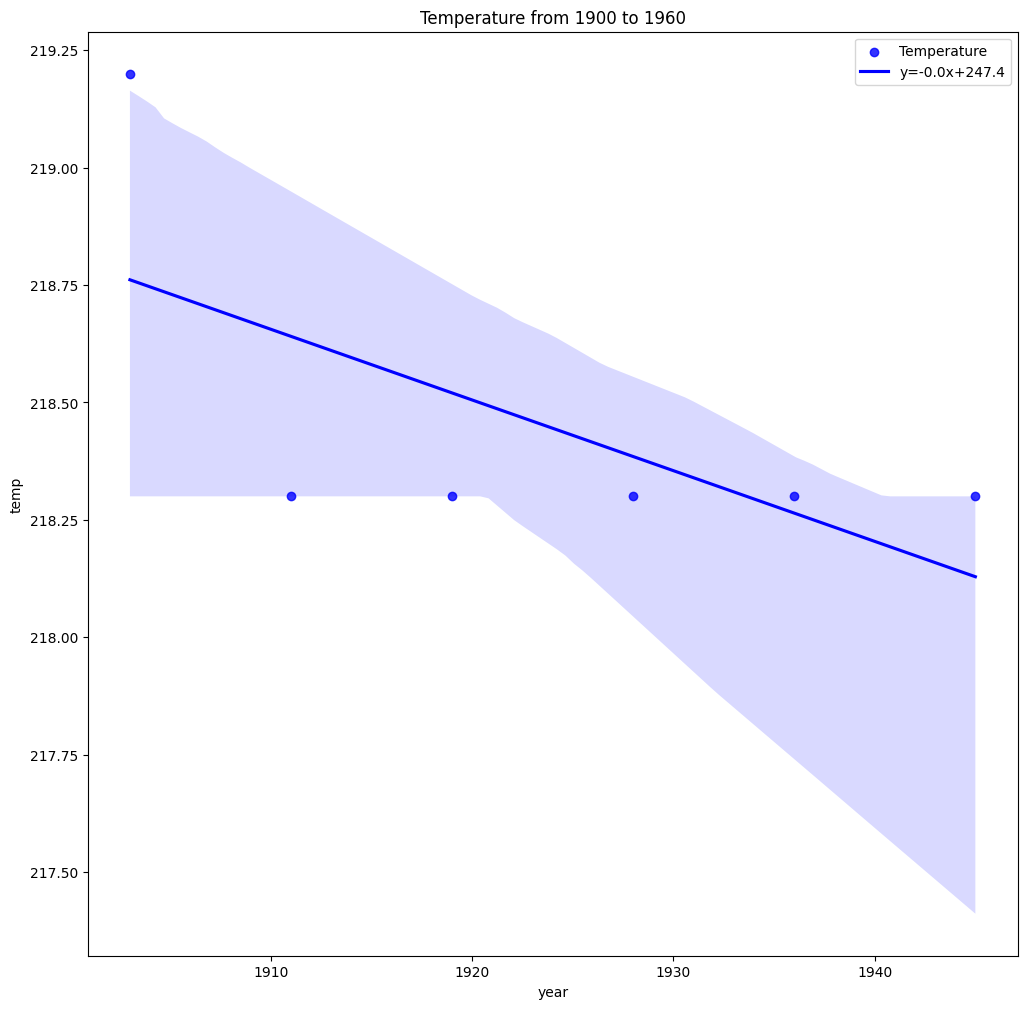

In [30]:
# to mask nan values so slope can be calculated
# https://stackoverflow.com/questions/13643363/linear-regression-of-arrays-containing-nans-in-python-numpy
mask = ~np.isnan(temp_CO2_from_1900to1960['year']) & ~np.isnan(temp_CO2_from_1900to1960['temp'])
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(temp_CO2_from_1900to1960['year'][mask],temp_CO2_from_1900to1960['temp'][mask])

# to plot a regression plot of Temperature and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
sns.regplot(x="year", y="temp", data=temp_CO2_from_1900to1960, color="b", ax=ax1, label="Temperature", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope3,intercept3)})
plt.title("Temperature from 1900 to 1960")
ax1.legend()

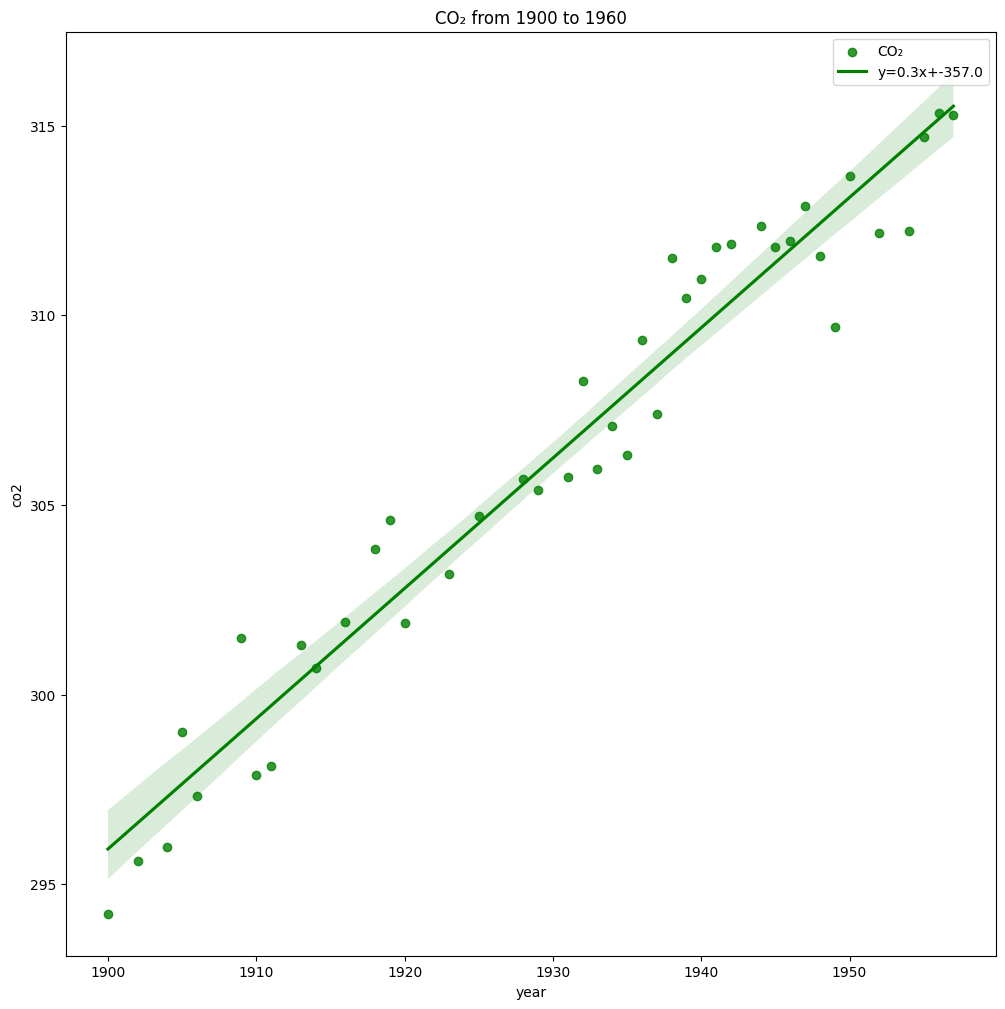

In [31]:
mask = ~np.isnan(temp_CO2_from_1900to1960['year']) & ~np.isnan(temp_CO2_from_1900to1960['co2'])
slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(temp_CO2_from_1900to1960['year'][mask],temp_CO2_from_1900to1960['co2'][mask])

# to plot a regression plot of Temperature and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
sns.regplot(x="year", y="co2", data=temp_CO2_from_1900to1960, color="g", ax=ax1, label="CO₂", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope4,intercept4)})
plt.title("CO₂ from 1900 to 1960")
ax1.legend()

## Irish Context

### Rainfall in Ireland

In [32]:
rainfall_ireland = pd.read_csv('CSV Files/rainfall_ireland.csv', dtype={'year': int})

In [33]:
rainfall_ireland.head()

,Year,Month,Rainfall
0,1711,1,16.4
1,1711,2,73.1
2,1711,3,121.2
3,1711,4,85.2
4,1711,5,66.6


In [34]:
# Sort the dataset per month and year
rainfall_ireland = rainfall_ireland.sort_values(['Month', 'Year'])
rainfall_ireland = rainfall_ireland.reset_index().drop(['index'], axis=1)
rainfall_ireland.head()

,Year,Month,Rainfall
0,1711,1,16.4
1,1712,1,42.6
2,1713,1,97.3
3,1714,1,42.4
4,1715,1,125.8


In [35]:
mean_years = []
std_dict = {}
for m in range(1,13):
  #Calcule mu and std values
  mu = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].mean()
  std = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].std()
  #Save mu and std values
  mean_years.append(mu)
  std_dict[m] = std

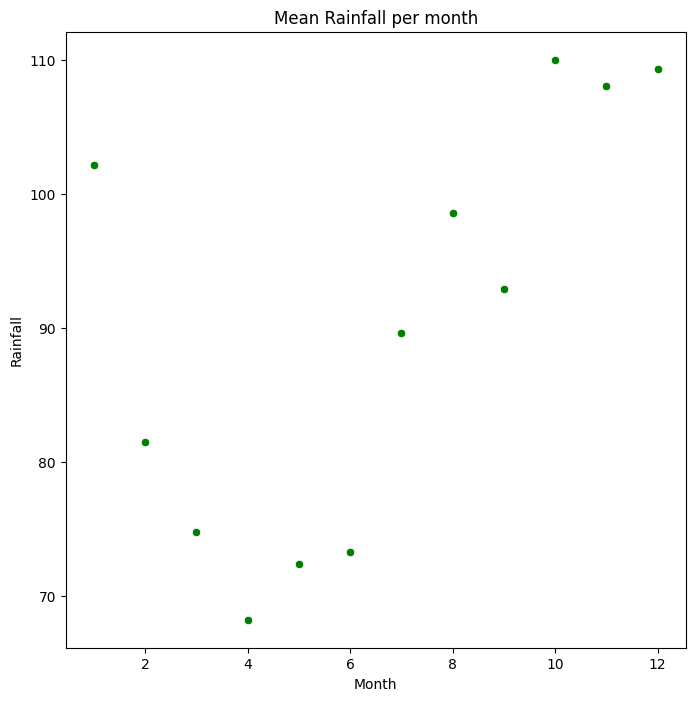

In [36]:
df_mean_years = pd.DataFrame(mean_years)
df_mean_years['Month'] = range(1, 13)
df_mean_years.columns = ['Rainfall', 'Month']
plt.figure(figsize=(8, 8))
sns.scatterplot(x='Month', y='Rainfall', data=df_mean_years,  color='green', sizes=20).set(title='Mean Rainfall per month')
plt.show()

In [37]:
ireland_rainfall_mean = []
std_dict = {}
for y in range(1711, 2016):
  #Calcule mu and std values
  mu = rainfall_ireland[rainfall_ireland.Year == y]['Rainfall'].mean()
  std = rainfall_ireland[rainfall_ireland.Year == y]['Rainfall'].std()
  #Save mu and std values
  ireland_rainfall_mean.append(mu)
  std_dict[y] = std

In [38]:
#Compute Rainfall anomalies
def anomaliesRainfall(rainfall_ireland):
  #Calcule mean by months from 1981-2010
  df_300y_rainfall = rainfall_ireland.query('1711 <= Year <= 2016')
  df_300y_rainfall = df_300y_rainfall.reset_index().drop(['index'], axis=1)
  mean_300y_rainfall = []
  for m in range(1,13):
    mu = rainfall_ireland[rainfall_ireland.Month == m]['Rainfall'].mean()
    mean_300y_rainfall.append(mu)

  #Compute SIE anomalies
  anomalies_rainfall_list = []
  for s in range(0, len(rainfall_ireland)):
    mean_300y_rainfall_index = rainfall_ireland.loc[s, 'Month']-1
    #Calcule anomalies
    anomalies_rainfall = rainfall_ireland.loc[s, 'Rainfall'] - mean_300y_rainfall[mean_300y_rainfall_index]
    anomalies_rainfall = anomalies_rainfall/mean_300y_rainfall[mean_300y_rainfall_index]*100
    #Save anomalies
    anomalies_rainfall_list.append(anomalies_rainfall)
  rainfall_ireland['AnomaliesRainfall'] = anomalies_rainfall_list
  return rainfall_ireland, mean_300y_rainfall

df_rainfall, mean_300y_rainfall = anomaliesRainfall(rainfall_ireland)

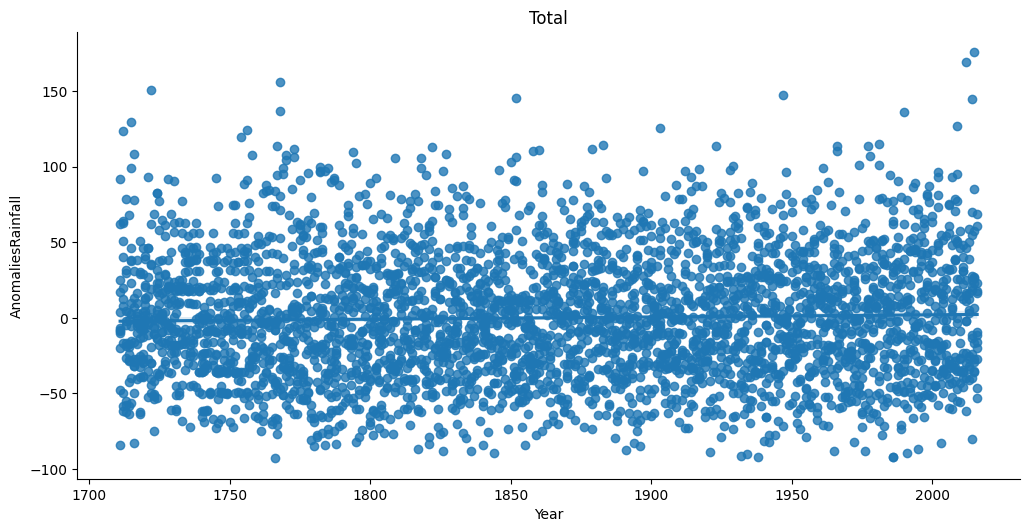

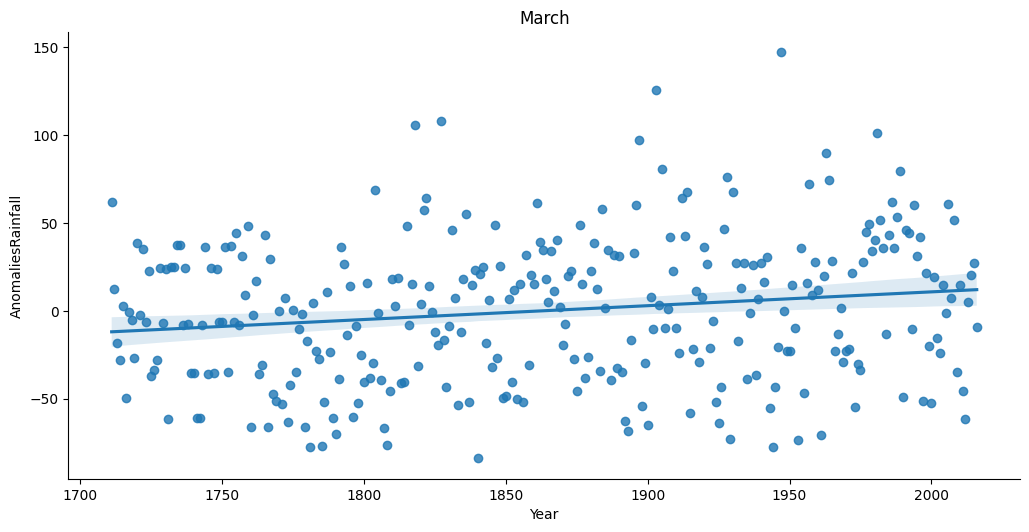

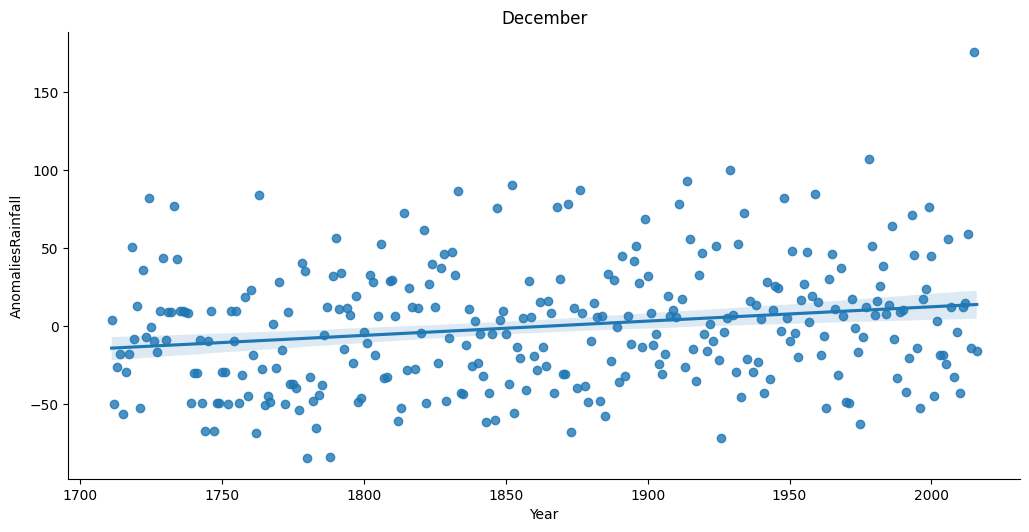

In [39]:
df_rainfall['Year'] = pd.to_numeric(df_rainfall['Year'])
#Total
sns.lmplot(x='Year', y='AnomaliesRainfall', data=df_rainfall, height=5.2, aspect=2).set(title='Total')
plt.show()
#March
sns.lmplot(x='Year', y='AnomaliesRainfall', data=df_rainfall[df_rainfall.Month == 3], height=5.2, aspect=2).set(title='March')
plt.show()
#December
sns.lmplot(x='Year', y='AnomaliesRainfall', data=df_rainfall[df_rainfall.Month == 12], height=5.2, aspect=2).set(title='December')
plt.show()

### Temperature in Ireland

In [40]:
west_ireland_temp = pd.read_csv('CSV Files/NUI-Galway_1851-1965.csv', encoding='ISO-8859-1',dtype={'year': int})
east_ireland_temp = pd.read_csv('CSV Files\Trinity-College-Dublin_1840-1959.csv', encoding='ISO-8859-1',dtype={'year': int})

west_ireland_temp = west_ireland_temp[['year', 'max_temp']]
east_ireland_temp = east_ireland_temp[['year', 'max_temp']]

In [41]:
malin_temp1 = pd.read_csv('CSV Files\Malin-Head_1885-1920.csv', encoding='ISO-8859-1',dtype={'year': int})
malin_temp2 = pd.read_csv('CSV Files\Malin-Head_1921-1955-data.csv', encoding='ISO-8859-1',dtype={'year': int})

In [42]:
malin_temp1 = malin_temp1[['year', 'max_temp']]
malin_temp2 = malin_temp2[['year', 'max_temp']]

north_ireland_temp = pd.concat([malin_temp1, malin_temp2])
north_ireland_temp.sort_values(by=['year'], ascending=True);

In [43]:
roches_temp1 = pd.read_csv('CSV Files\Roches-Point_1872-1920.csv', encoding='ISO-8859-1',dtype={'year': int})
roches_temp2 = pd.read_csv('CSV Files\Roches-Point_1921-1956.csv', encoding='ISO-8859-1',dtype={'year': int})

In [44]:
roches_temp1 = roches_temp1[['year', 'max_temp']]
roches_temp2 = roches_temp2[['year', 'max_temp']]

south_ireland_temp = pd.concat([roches_temp1, roches_temp2])
south_ireland_temp.sort_values(by=['year'], ascending=True);

In [45]:
all_ireland_temp = pd.concat([west_ireland_temp, east_ireland_temp, north_ireland_temp, south_ireland_temp])
all_ireland_temp.sort_values(by=['year'], ascending=True);

In [46]:
# to calculate max temperature
ireland_temp_max = []
std_dict = {}
for y in range(1851, 1957):
  #Calcule mu and std values
  mu = all_ireland_temp[all_ireland_temp.year == y]['max_temp'].max()
  #Save mu value
  ireland_temp_max.append(mu)


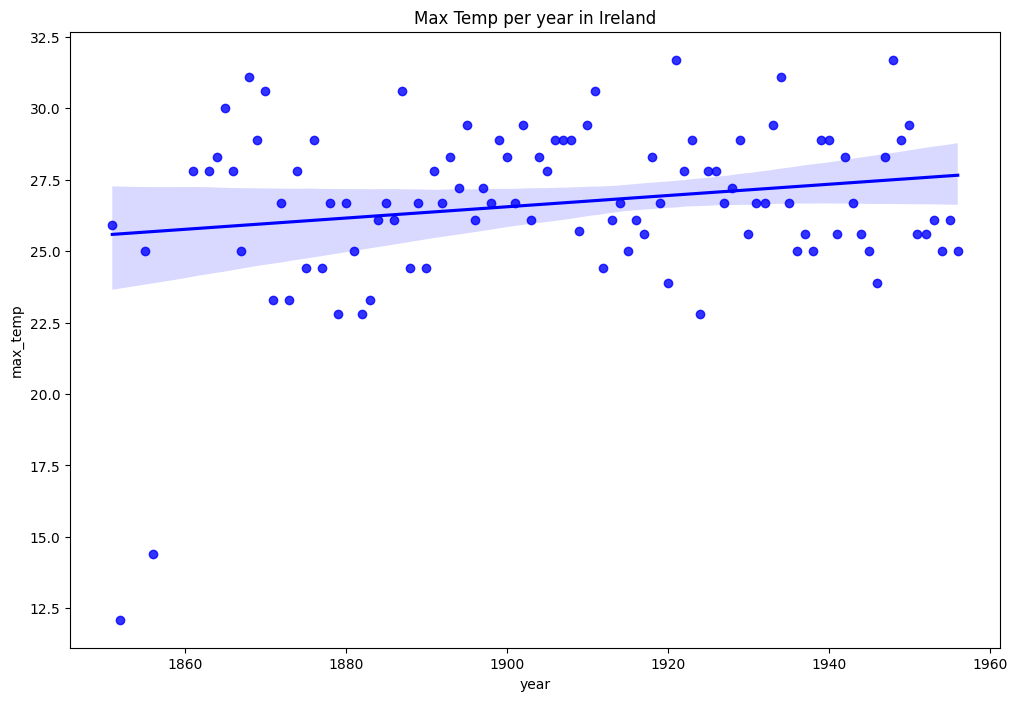

In [47]:
# to plot max temperature
df_ireland_temp_max = pd.DataFrame(ireland_temp_max)
df_ireland_temp_max['year'] = range(1851, 1957)
df_ireland_temp_max.columns = ['max_temp', 'year']
plt.figure(figsize=(12, 8))
sns.regplot(x = "year", y = "max_temp", data = df_ireland_temp_max, color='blue').set(title='Max Temp per year in Ireland')
plt.show()

In [48]:
# to calculate mean temperature
ireland_temp_mean = []
std_dict = {}
for y in range(1851, 1957):
  #Calcule mu and std values
  mu = all_ireland_temp[all_ireland_temp.year == y]['max_temp'].mean()
  std = all_ireland_temp[all_ireland_temp.year == y]['max_temp'].std()
  #Save mu and std values
  ireland_temp_mean.append(mu)
  std_dict[y] = std

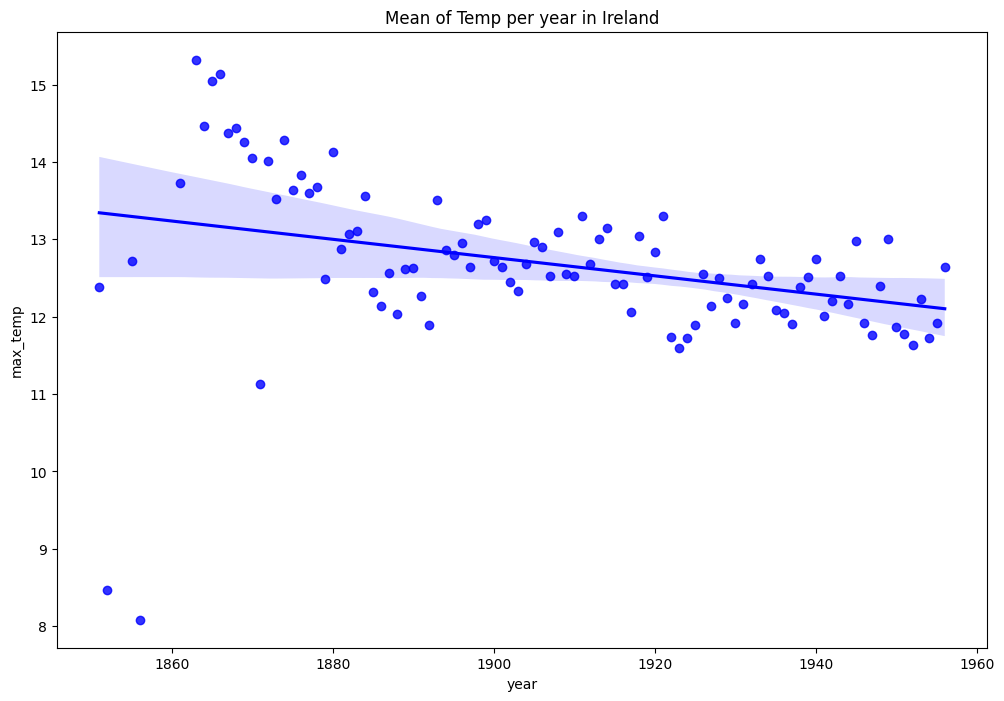

In [49]:
# to plot mean temperature
df_ireland_temp_mean = pd.DataFrame(ireland_temp_mean)
df_ireland_temp_mean['year'] = range(1851, 1957)
df_ireland_temp_mean.columns = ['max_temp', 'year']
plt.figure(figsize=(12, 8))
sns.regplot(x = "year", y = "max_temp", data = df_ireland_temp_mean, color='blue').set(title='Mean of Temp per year in Ireland')
plt.show()

### Plotting Temperature and Rainfall in Ireland

In [50]:
years_temp = list(range(1851, 1957));

ireland_meantemp = pd.DataFrame({'year': years_temp, 'temp_ireland': ireland_temp_mean})
ireland_meantemp.temp_ireland = ireland_meantemp.temp_ireland.round()
#ireland_temp.to_csv("ireland_temp.csv", encoding='utf-8', index=False)

ireland_maxtemp = pd.DataFrame({'year': years_temp, 'temp_ireland': ireland_temp_max})
ireland_maxtemp.temp_ireland = ireland_maxtemp.temp_ireland.round()

years_rainfall = list(range(1711, 2016));

ireland_rainfall = pd.DataFrame({'year': years_rainfall, 'rainfall_ireland': ireland_rainfall_mean})
ireland_rainfall.rainfall_ireland = ireland_rainfall.rainfall_ireland.round(2)
#ireland_rainfall.to_csv("ireland_rainfall.csv", encoding='utf-8', index=False)

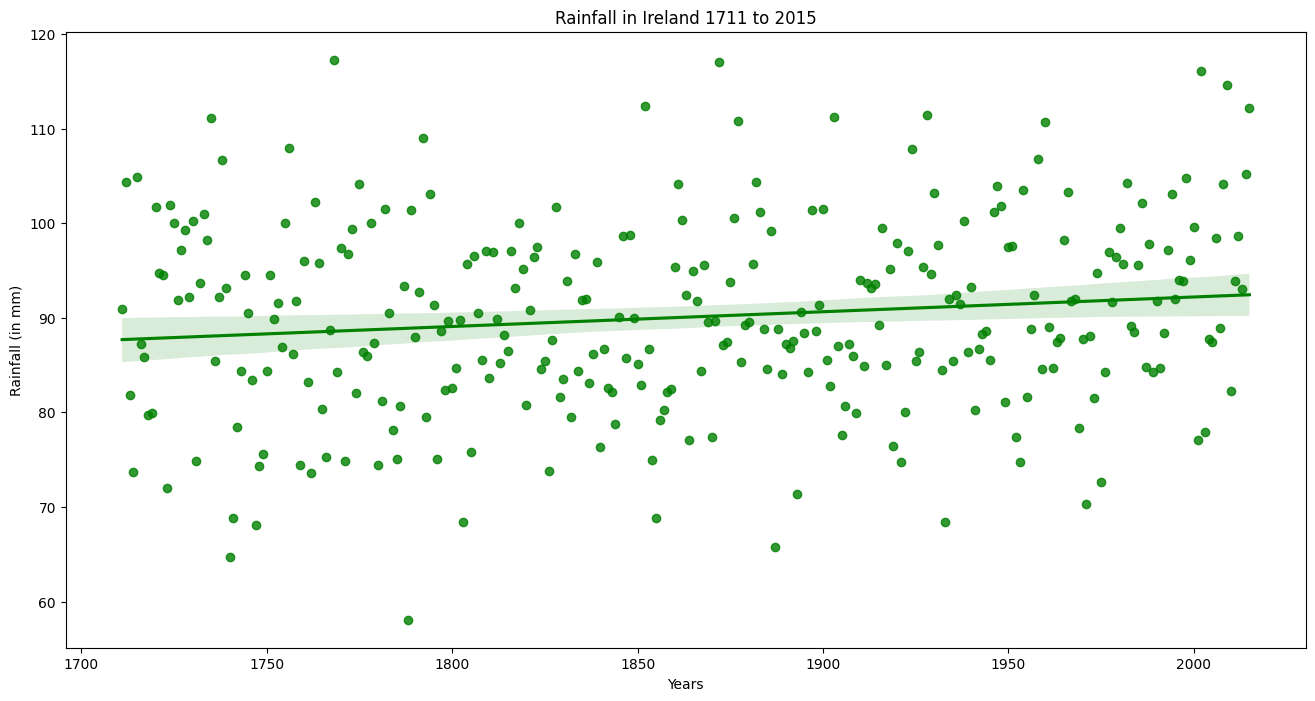

<Figure size 640x480 with 0 Axes>

In [51]:
# plotting rainfall in Ireland
plt.figure(figsize=(16,8))
sns.regplot(x="year", y="rainfall_ireland", data=ireland_rainfall, color="g", label="Rainfall (mm)")
plt.xlabel('Years')
plt.ylabel('Rainfall (in mm)')
plt.title("Rainfall in Ireland 1711 to 2015")
plt.show()
plt.clf()

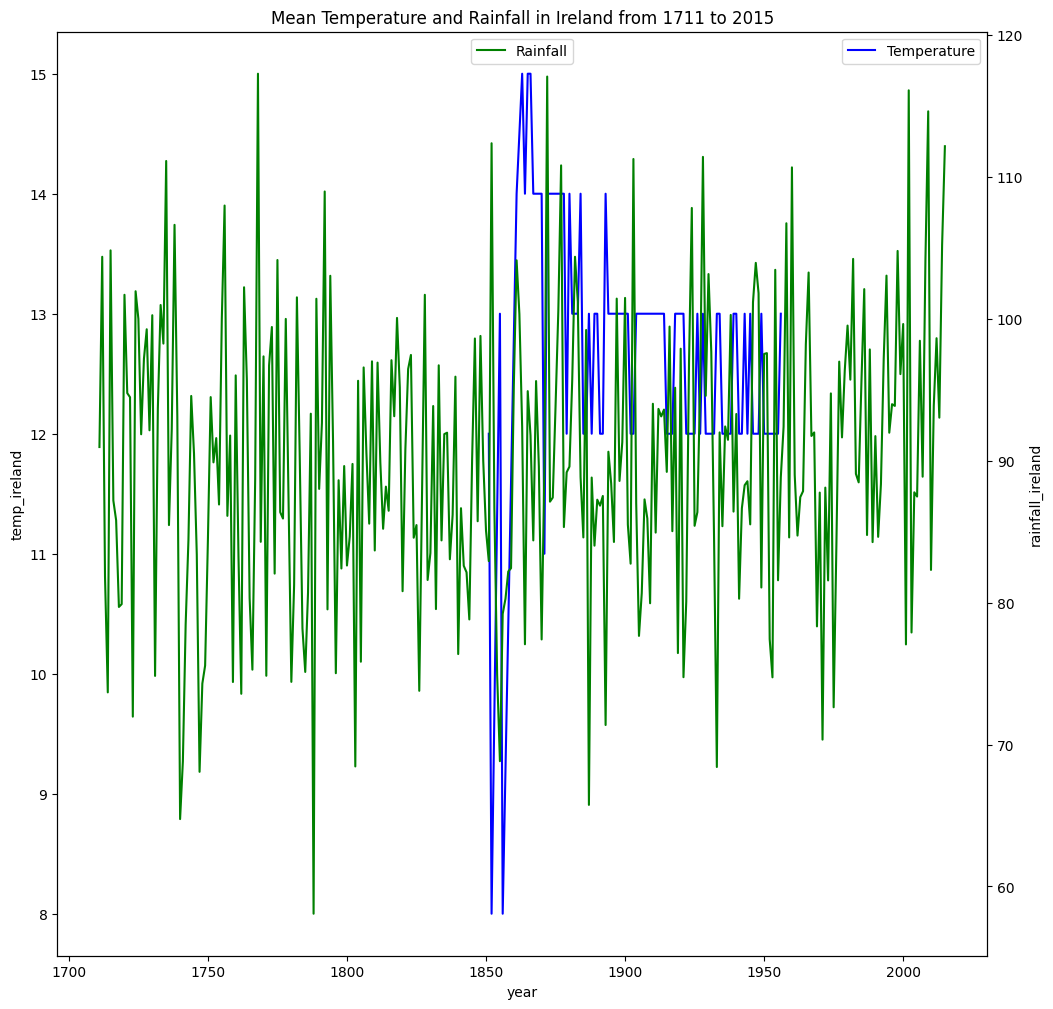

In [52]:
# plotting rainfall and mean temperature in Ireland
# no trends visible
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp_ireland", data=ireland_meantemp, color="b", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="rainfall_ireland", data=ireland_rainfall, color="g", ax=ax2, label="Rainfall")
plt.title("Mean Temperature and Rainfall in Ireland from 1711 to 2015")
plt.legend(loc='upper center');

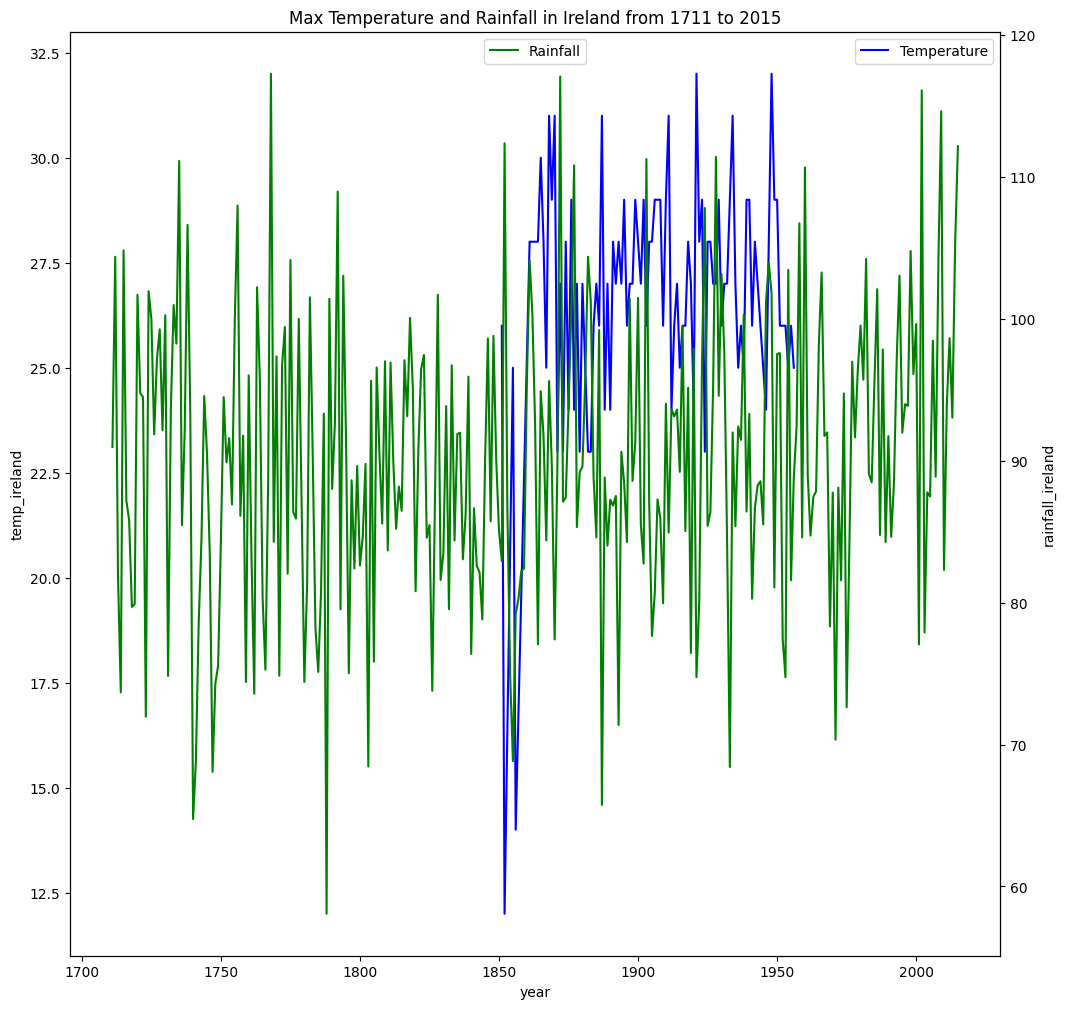

In [53]:
# plotting rainfall and max temperature in Ireland
# no trends visible
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp_ireland", data=ireland_maxtemp, color="b", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="rainfall_ireland", data=ireland_rainfall, color="g", ax=ax2, label="Rainfall")
plt.title("Max Temperature and Rainfall in Ireland from 1711 to 2015")
plt.legend(loc='upper center');

From the plots above, there appears to be no visible trend in terms of rainfall and temperature in Ireland using the data obtained in the analysis. The slight changes from year to year represent noise in the time series, which describes the variance and volatility of the measurements. 

## Combining Data into one Dataframe

In [54]:
combined_data = temp_CO2_present.merge(df_seaice_mean, on='year', how='outer').merge(ireland_meantemp, on='year', how='outer').merge(ireland_rainfall, on='year', how='outer')
combined_data = combined_data.sort_values('co2', ascending=False).drop_duplicates('year').sort_index()
combined_data.sort_values(by=['year'], inplace=True, ascending=True);
#temp_CO2_present = temp_CO2_present.astype({'year':'int'})
combined_data.to_csv('combined_data.csv', index=False)
combined_data.to_json('combined_data.json', orient='records', lines=False, indent=4)

### Data Analysis

In [55]:
combined_data.describe()

,year,temp,co2,sea_ice,temp_ireland,rainfall_ireland
count,8860.000000,5871.000000,2963.000000,41.000000,99.000000,305.000000
mean,-224049.577878,214.963763,233.870297,11.474634,12.727273,90.061541
std,231616.228990,15.354087,35.108064,0.674237,1.067308,10.096447
min,-818144.000000,207.900000,171.600000,10.180000,8.000000,58.080000
25%,-363744.000000,210.900000,205.495000,10.920000,12.000000,84.270000
50%,-127693.000000,212.900000,231.600000,11.690000,13.000000,89.600000
75%,-33575.250000,216.100000,252.900000,12.020000,13.000000,96.990000
max,2022.000000,418.530000,418.530000,12.470000,15.000000,117.280000


In [56]:
combined_data.dtypes

year                  int64
temp                float64
co2                 float64
sea_ice             float64
temp_ireland        float64
rainfall_ireland    float64
dtype: object

In [57]:
print('Correlation:')
correlations = combined_data.select_dtypes(exclude=[int])
correlations.corr().round(2) 

Correlation:


,temp,co2,sea_ice,temp_ireland,rainfall_ireland
temp,1.00,0.93,-0.95,-0.39,0.10
co2,0.93,1.00,-0.95,-0.66,0.31
sea_ice,-0.95,-0.95,1.00,NaN,-0.11
temp_ireland,-0.39,-0.66,NaN,1.00,-0.07
rainfall_ireland,0.10,0.31,-0.11,-0.07,1.00


As already visualised with the line graphs plotted above, there is a high level of correlation between temperature and CO₂ levels over the past 800 thousand years.

From the data displayed in the table above, the value of 0.93 for correlation between temperature and CO₂ levels indicate the two variables are linearly related. This means they change together at a constant rate. A value of +1 or-1 indicates complete correlation, while a value of 0 indicates complete absence of correlation. The closer the correlation value is to 1, the greataer the correlation is between the variables.

### Distribution of the Variables

- Histograms

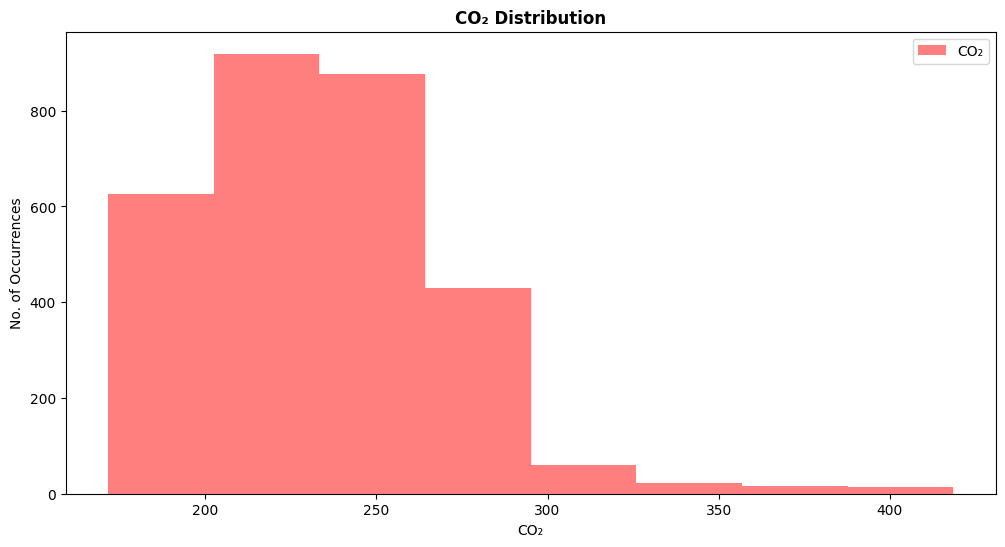

In [58]:
# Plot a Histogram for CO2 Distribution

fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("CO₂ Distribution", fontweight='bold') # to set the title of the plot
ax.set(xlabel='CO₂')    # to set the x axis title
ax.set(ylabel="No. of Occurrences") # to set the y axis title
ax.hist(combined_data['co2'], bins=8, alpha=0.5, label="CO₂", color='red')  # to plot a histogram of CO2 distribution
ax.legend(loc='upper right'); # to place the legend of the plot in the upper right

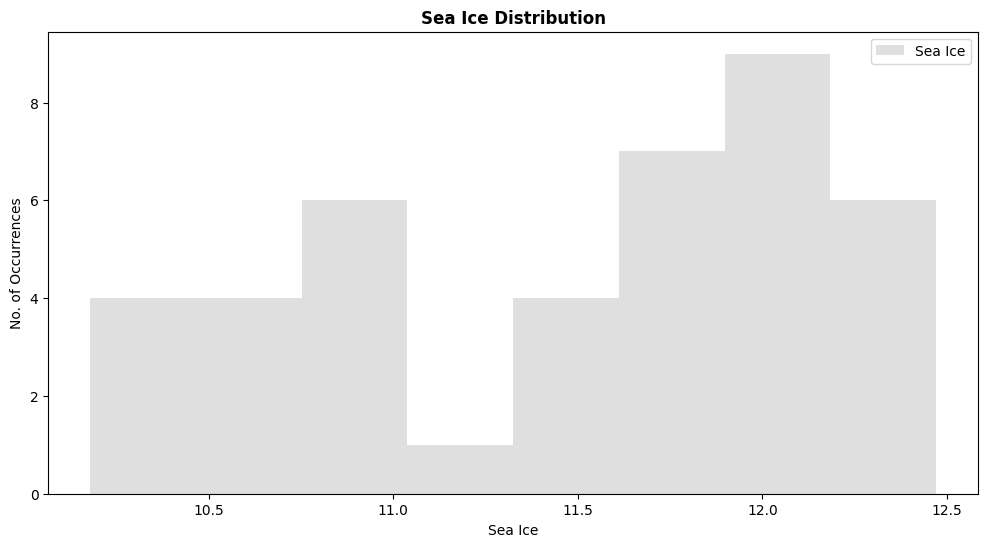

In [59]:
# Plot a Histogram for Sea Ice Distribution

fig, ax = plt.subplots(figsize = (12,6))

ax.set_title("Sea Ice Distribution", fontweight='bold') # to set the title of the plot
ax.set(xlabel='Sea Ice')    # to set the x axis title
ax.set(ylabel="No. of Occurrences") # to set the y axis title
ax.hist(combined_data['sea_ice'], bins=8, alpha=0.5, label="Sea Ice", color='silver')  # to plot a histogram of sea ice distribution
ax.legend(loc='upper right'); # to place the legend of the plot in the upper right

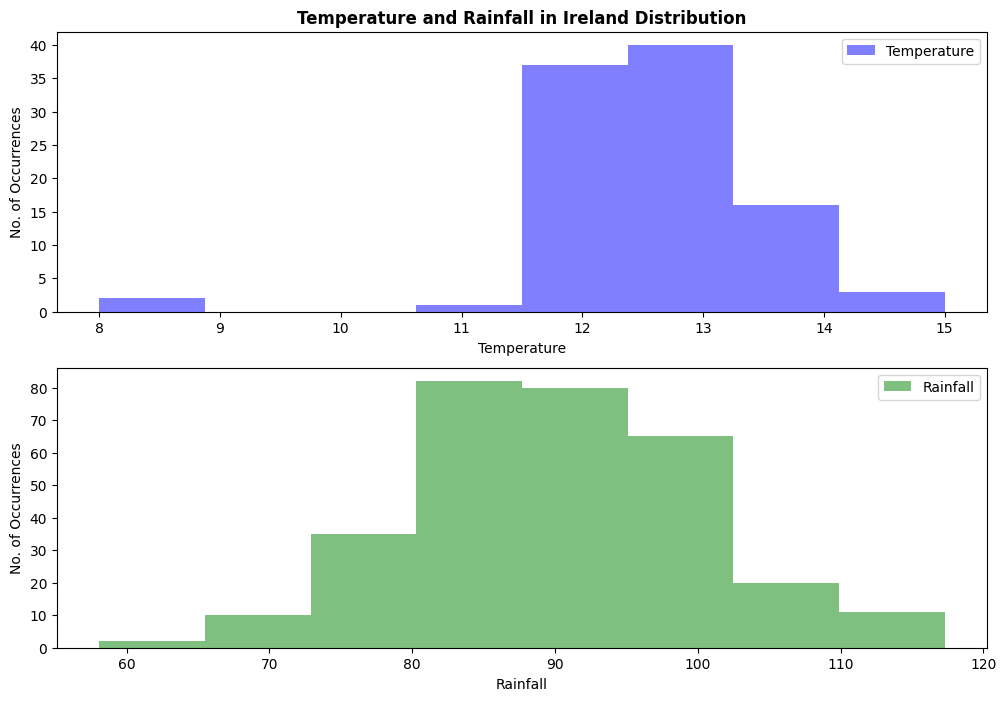

In [60]:
# Plot a Histogram for Temperature and Rainfall in Ireland Distribution

fig, axes = plt.subplots(2, figsize = (12,8))  # to create two vertically stacked subplots

axes[0].set_title("Temperature and Rainfall in Ireland Distribution", fontweight='bold')
axes[0].set(xlabel='Temperature')
axes[0].set(ylabel="No. of Occurrences")
axes[0].hist(combined_data['temp_ireland'], bins=8, alpha=0.5, label="Temperature", color='blue')
axes[0].legend(loc='upper right')

axes[1].set(xlabel='Rainfall')
axes[1].set(ylabel="No. of Occurrences")
axes[1].hist(combined_data['rainfall_ireland'], bins=8, alpha=0.5, label="Rainfall", color='green')
axes[1].legend(loc='upper right')

epica dc determined CO2 and temperature data from ice cores - the temperature is inferred from the isotopic composition of the water molecules released by melting the ice cores.

For this reason, it is difficult to compare the temperature data collected for Ireland to the over 800 thousand years of data collected worldwide.
I have searched online for ways to compare this data to degrees Celsius, however I havent been able to find anything concrete on this matter.

https://www.scientificamerican.com/article/how-are-past-temperatures/

- Pairplots

In [61]:
combined_2 = combined_data[['temp', 'co2', 'sea_ice', 'temp_ireland', 'rainfall_ireland']]

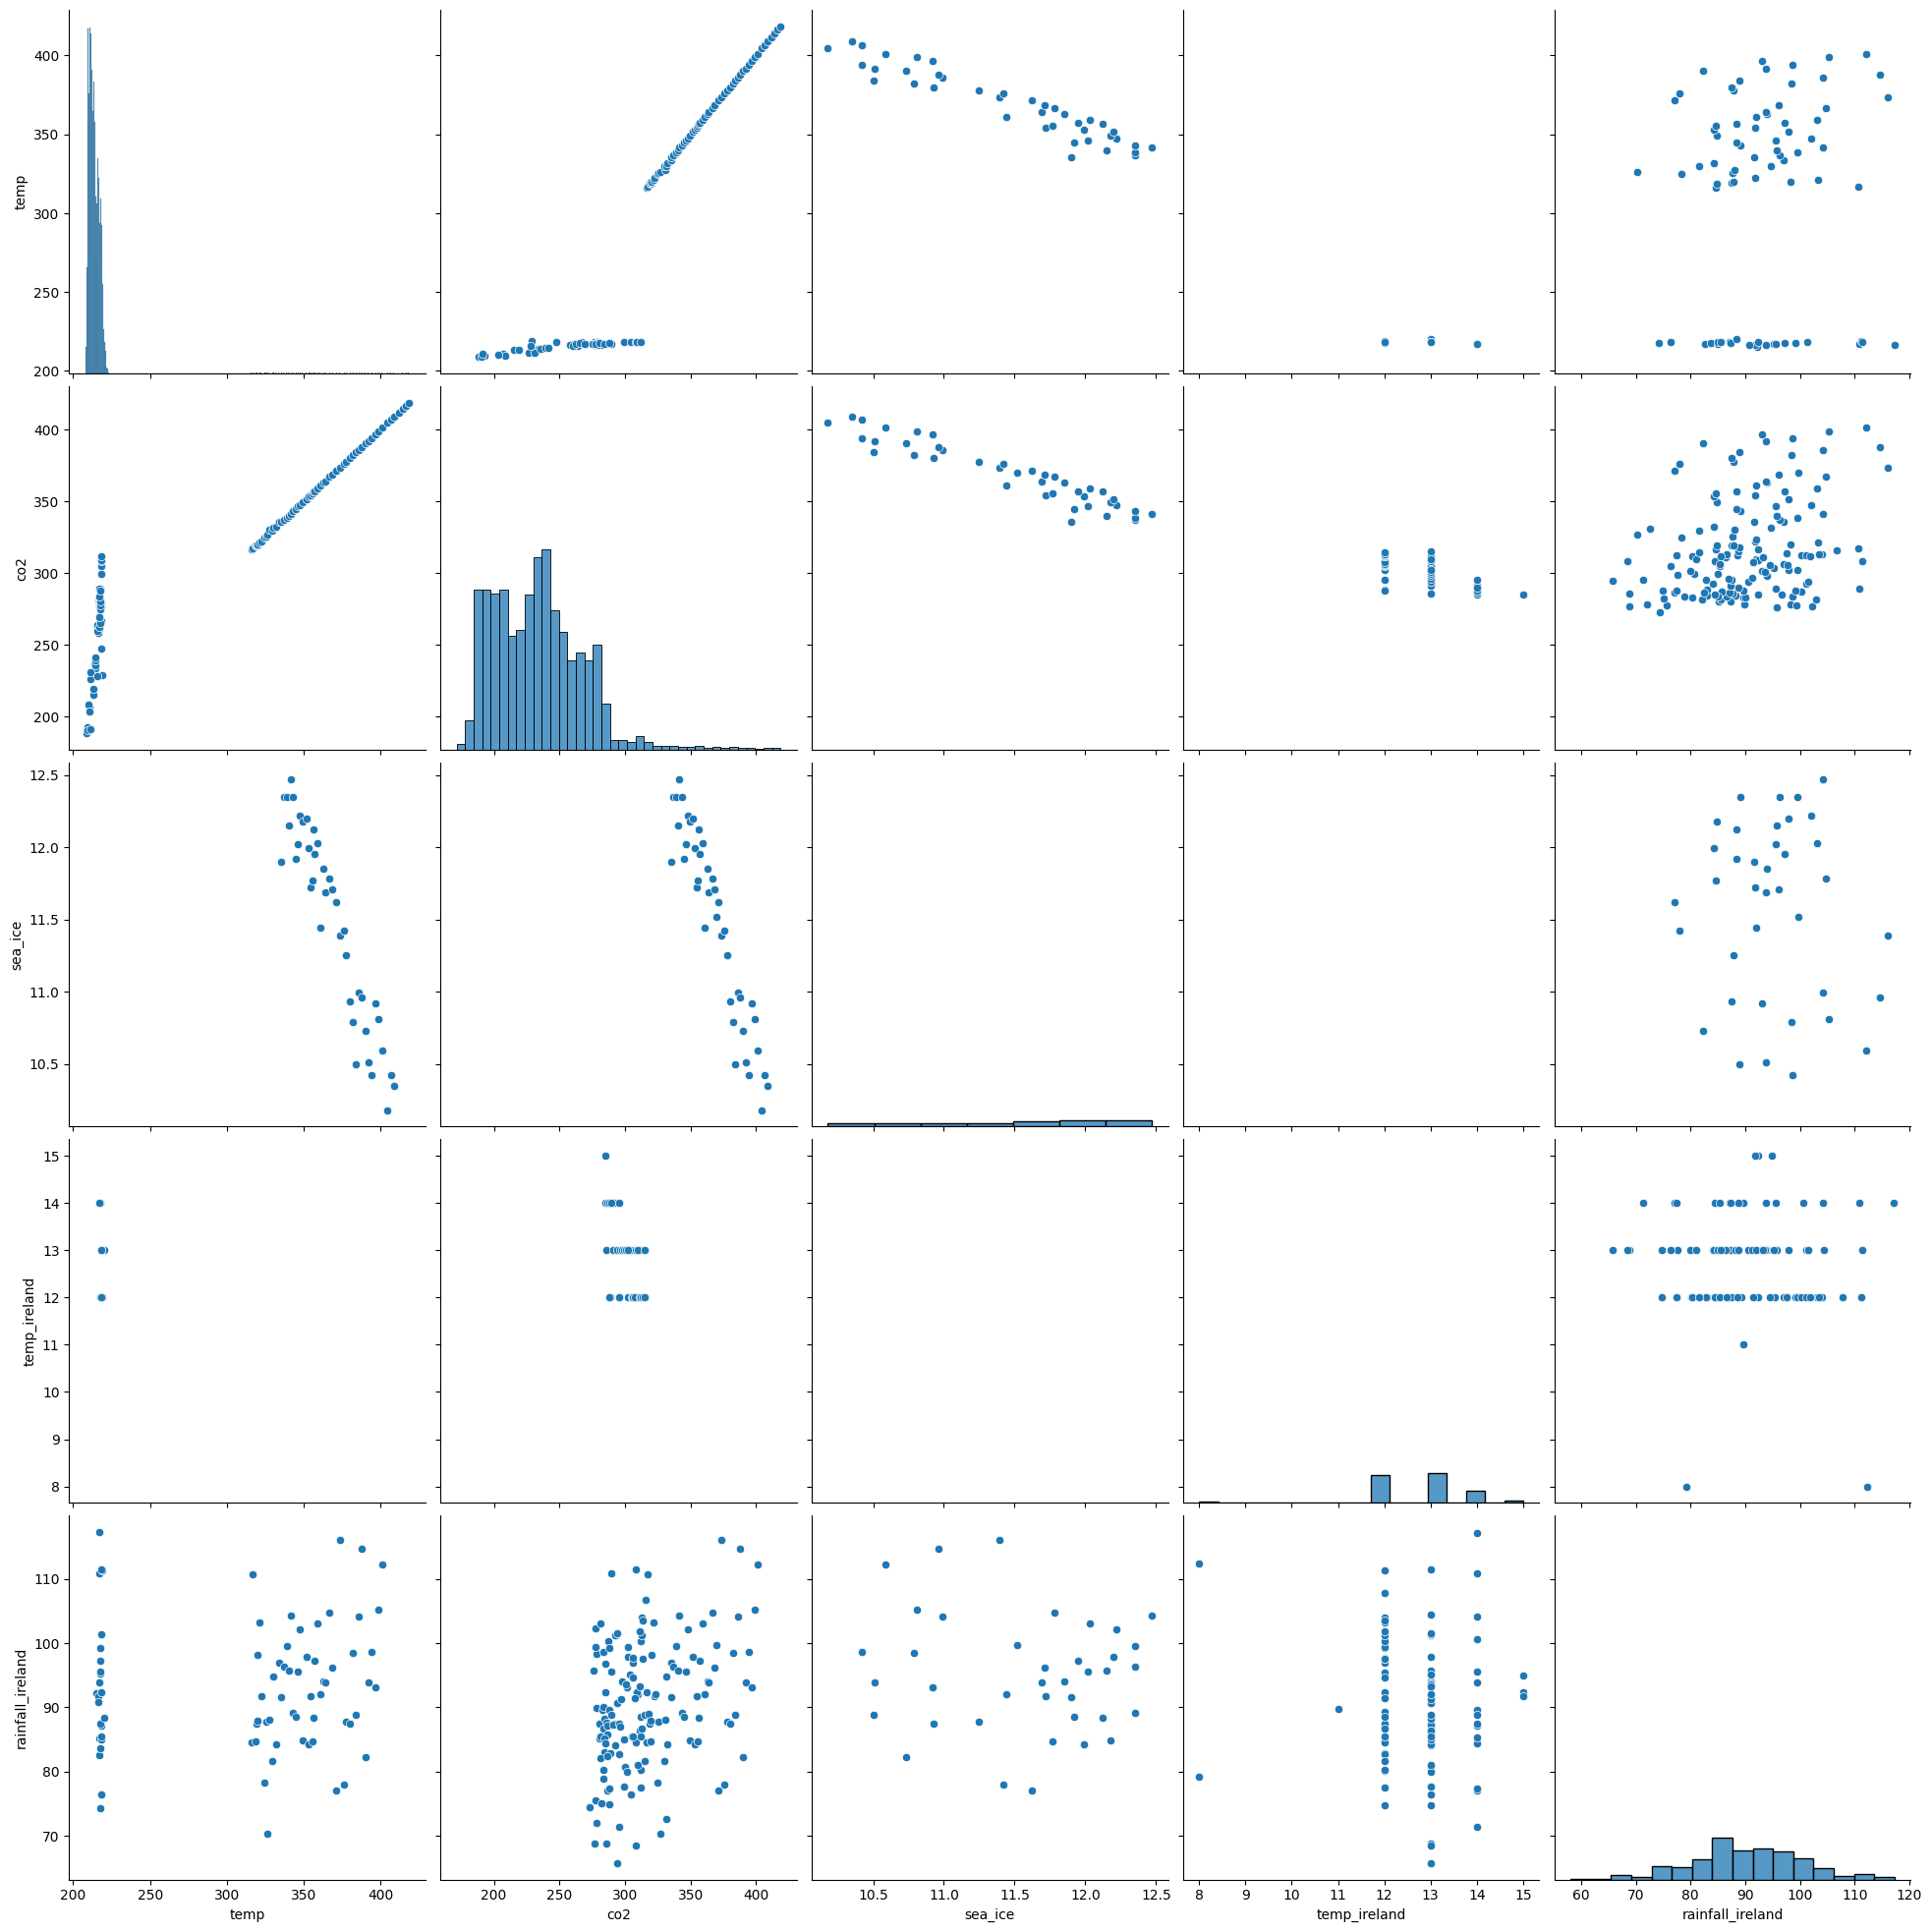

In [62]:
# a pairplot using the seaborn module, to display distributions of the variables in the dataset
sns.pairplot(combined_2, height=4, palette=['blue', 'purple', 'blueviolet'])

- Boxplots

Text(0.5, 1.0, 'Boxplots of Temperature and CO2')

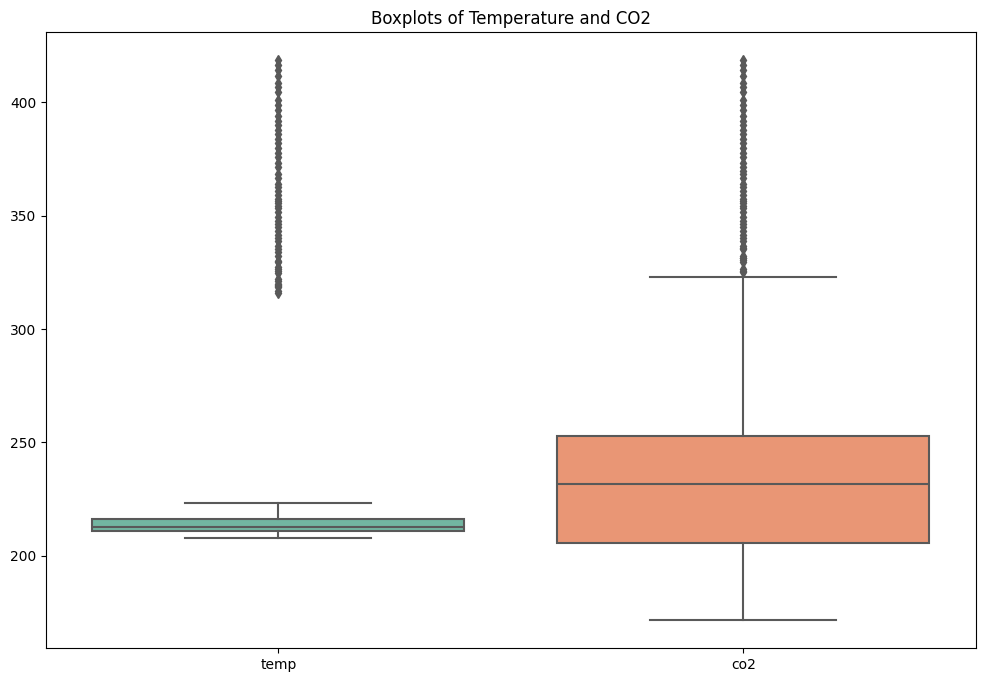

In [63]:
# plotting a boxplot of temperature and CO2

fig, ax = plt.subplots(figsize=(12,8))
df2 = combined_data[['temp', 'co2']]
ax = sns.boxplot(data=df2, orient="v", palette="Set2")  # to create a boxplot using seaborn
ax.set_title("Boxplots of Temperature and CO2")
# https://stackoverflow.com/questions/66833728/boxplots-with-seaborn-for-all-variables-in-a-dataset-at-once

Text(0.5, 1.0, 'Boxplots of Temperature and Rainfall in Ireland')

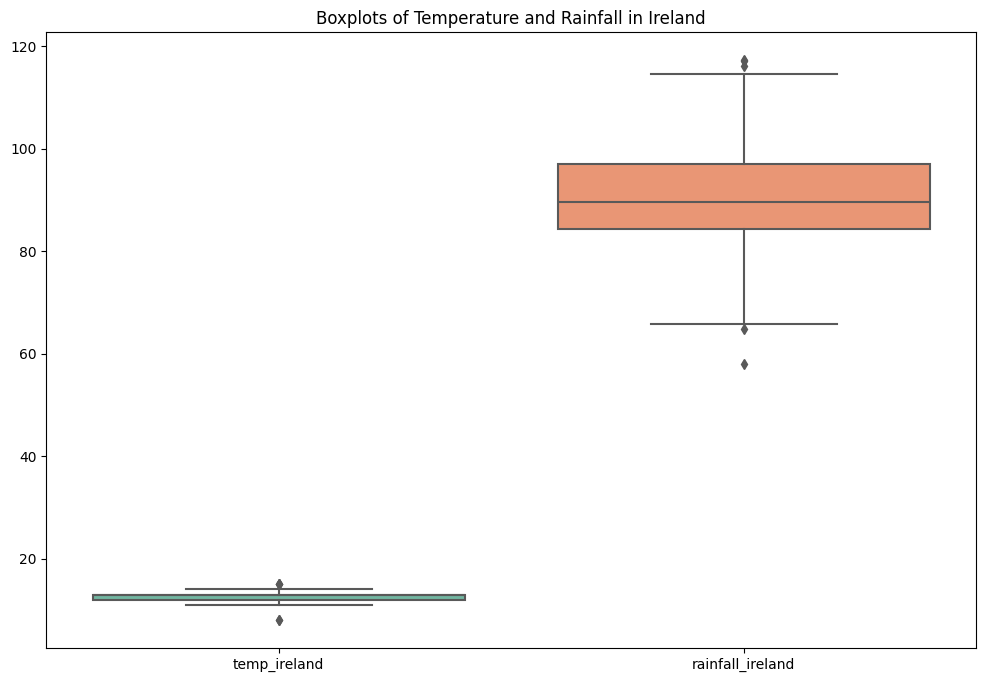

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
df3 = combined_data[['temp_ireland', 'rainfall_ireland']]
ax = sns.boxplot(data=df3, orient="v", palette="Set2")  # to create a boxplot using seaborn
ax.set_title("Boxplots of Temperature and Rainfall in Ireland")

Text(0.5, 1.0, 'Boxplot of Sea Ice')

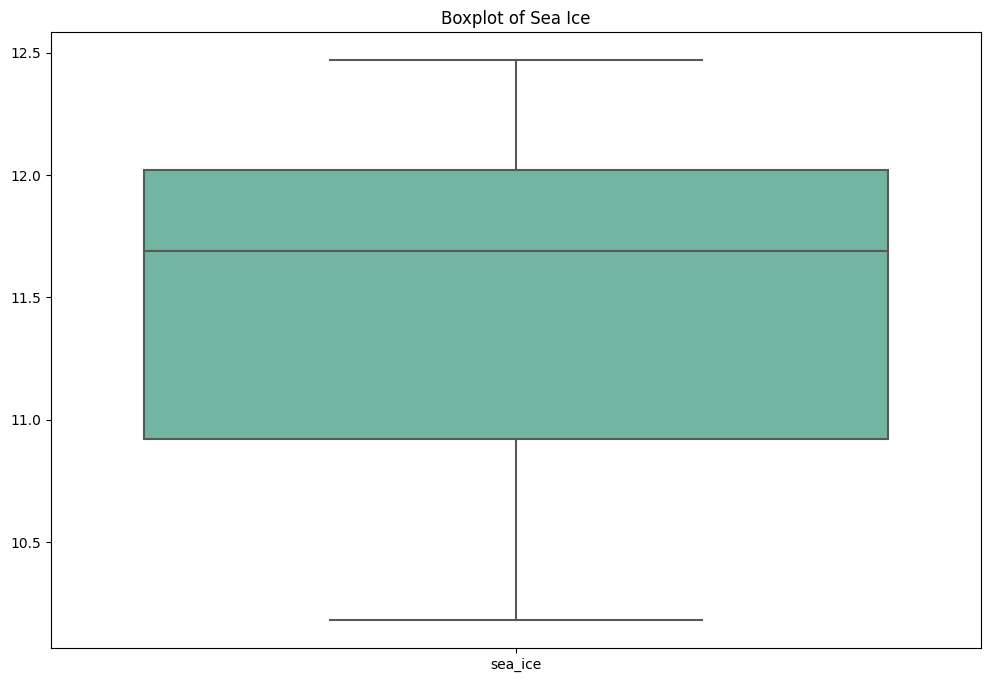

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
df4 = combined_data[['sea_ice']]
ax = sns.boxplot(data=df4, orient="v", palette="Set2")  # to create a boxplot using seaborn
ax.set_title("Boxplot of Sea Ice")

### Comparing Temperature, CO₂ and Sea Ice Variables

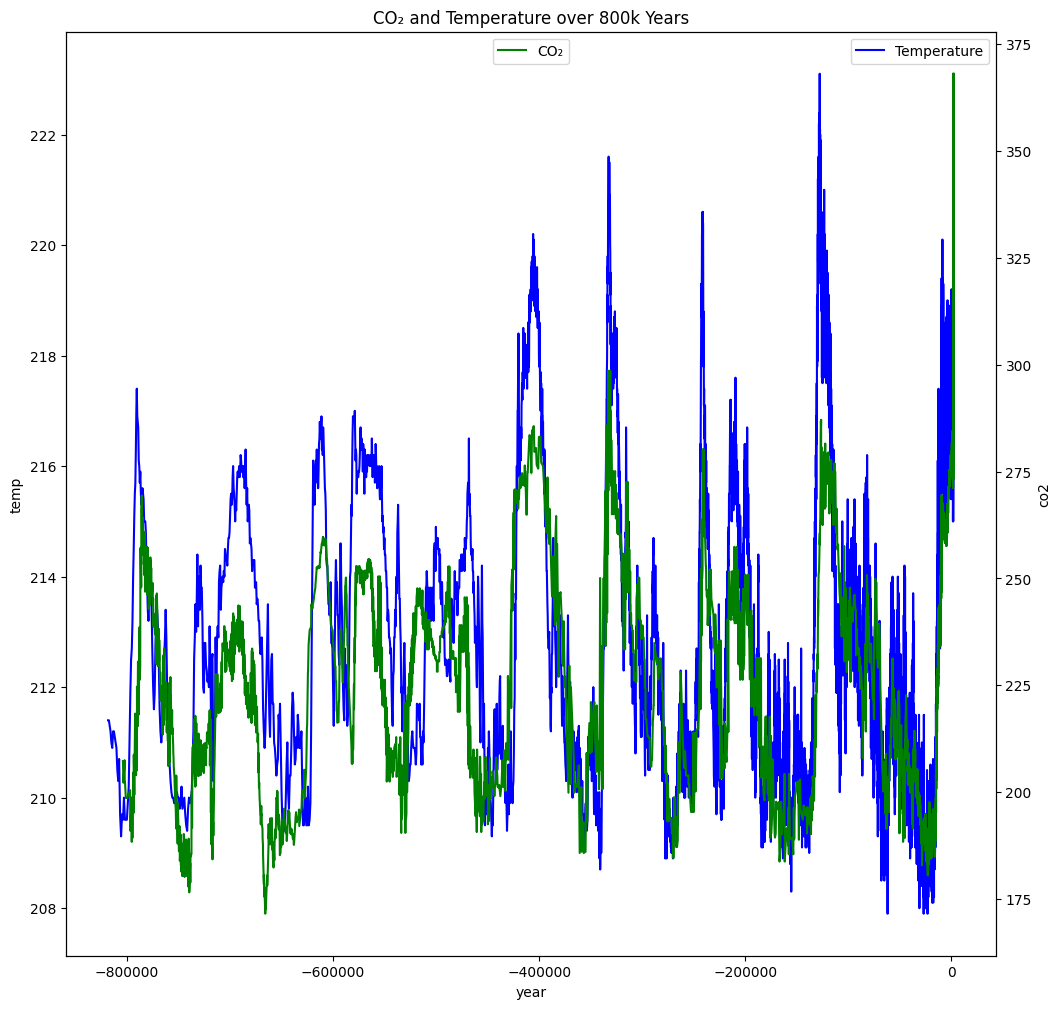

In [66]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp", data=temp_CO2, color="b", label="Temperature")
ax2 = plt.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2, color="g", ax=ax2, label="CO₂")
plt.title("CO₂ and Temperature over 800k Years")
plt.legend(loc='upper center')

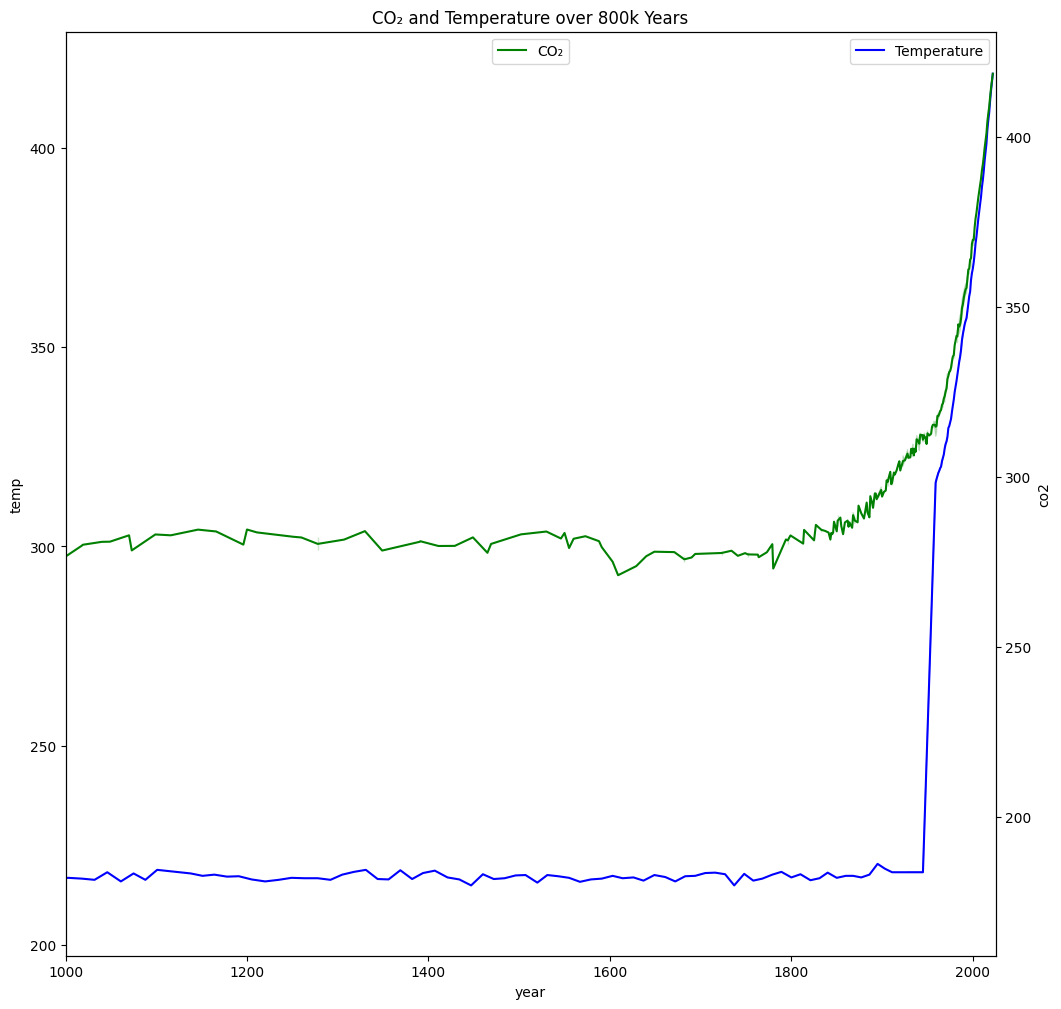

In [67]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="g", ax=ax2, label="CO₂")
ax1.set_xlim(1000, 2025)
ax2.set_xlim(1000, 2025)
plt.title("CO₂ and Temperature over 800k Years")
plt.legend(loc='upper center')

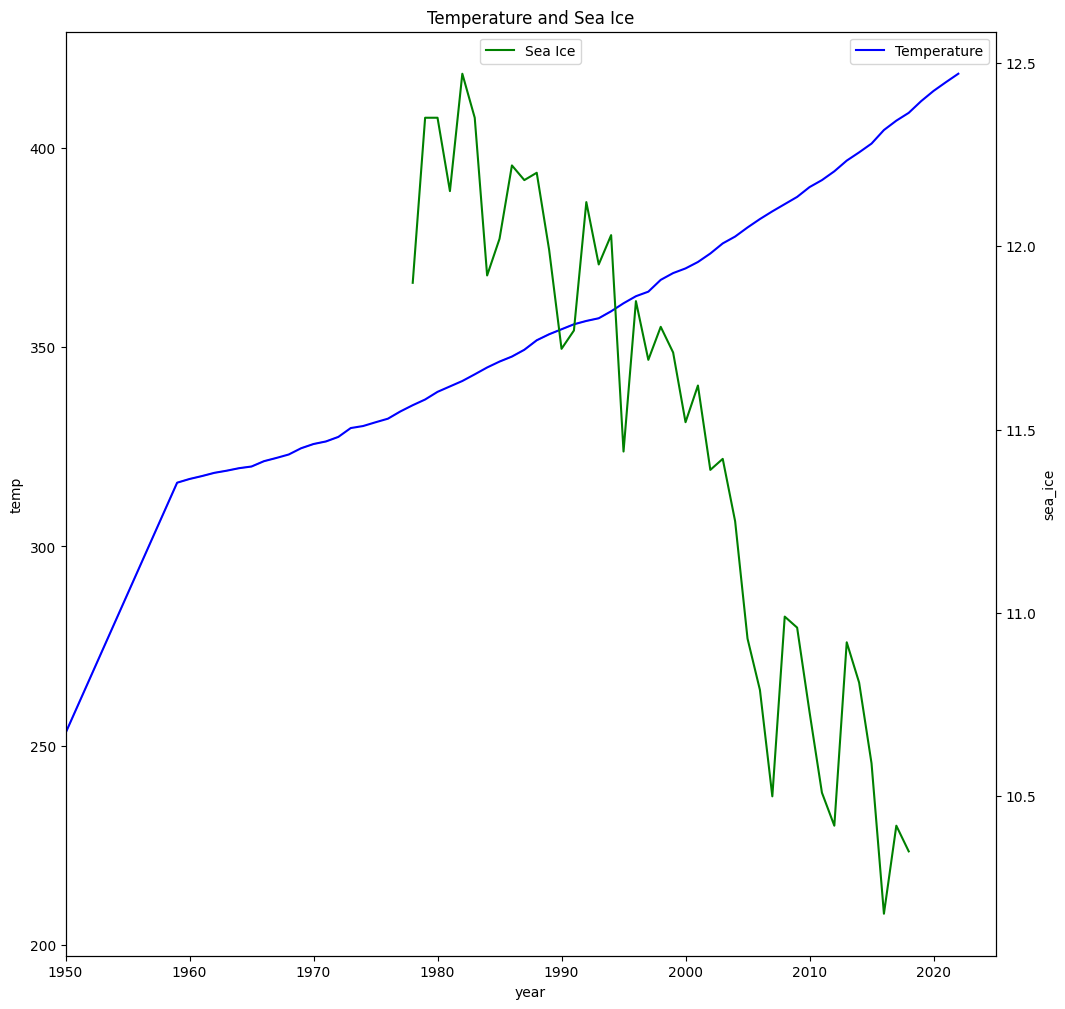

In [68]:
# to plot temperature vs sea ice
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="temp", data=temp_CO2_present, color="b", ax=ax1, label="Temperature")
sns.lineplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice")
ax1.set_xlim(1950, 2025)
ax2.set_xlim(1950, 2025)
plt.title("Temperature and Sea Ice")
plt.legend(loc='upper center')

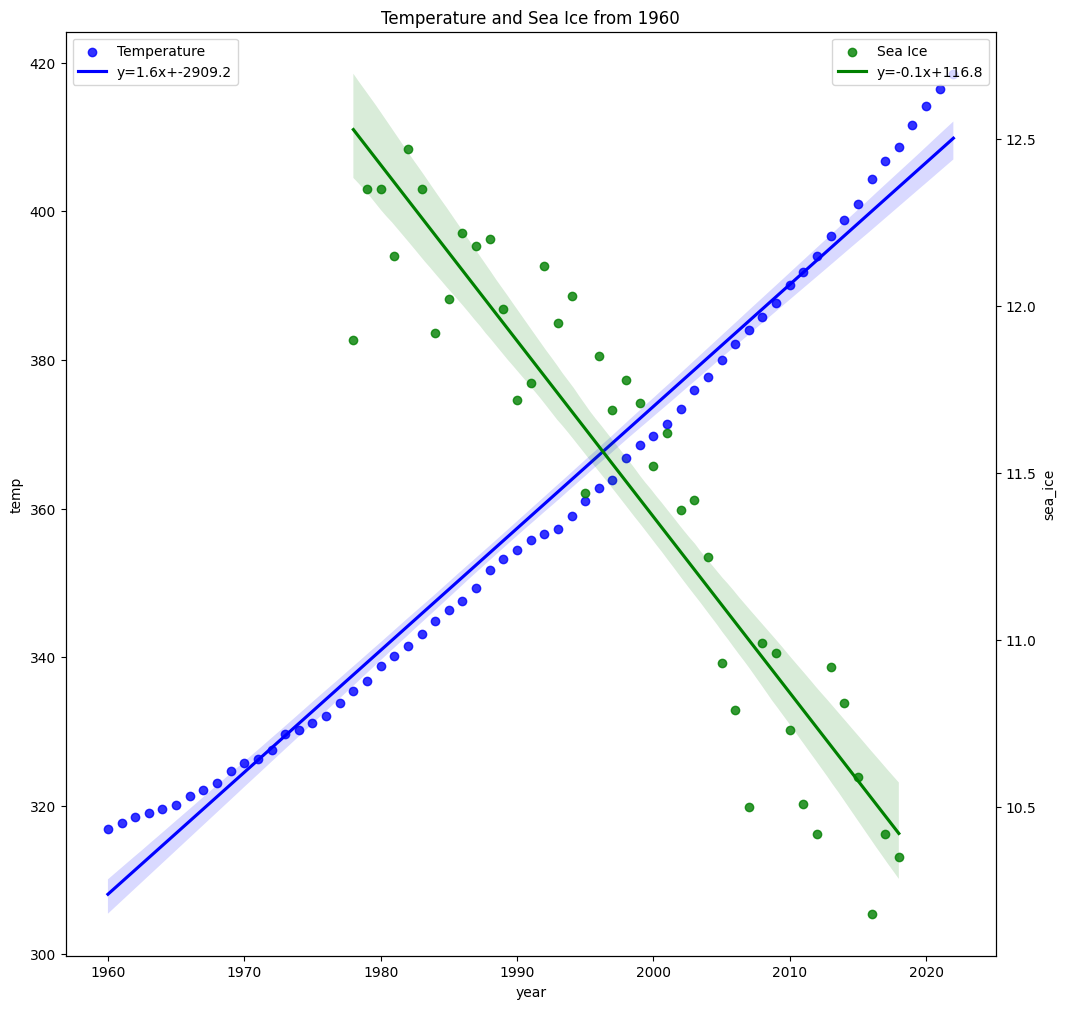

In [69]:
from scipy import stats

# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(temp_CO2_from_1960['year'],temp_CO2_from_1960['temp'])
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(df_seaice_mean['year'],df_seaice_mean['sea_ice'])

# to plot a regression plot of Temperature and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.regplot(x="year", y="temp", data=temp_CO2_from_1960, color="b", ax=ax1, label="Temperature", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
sns.regplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1)})
plt.title("Temperature and Sea Ice from 1960")
ax1.legend()
ax2.legend()

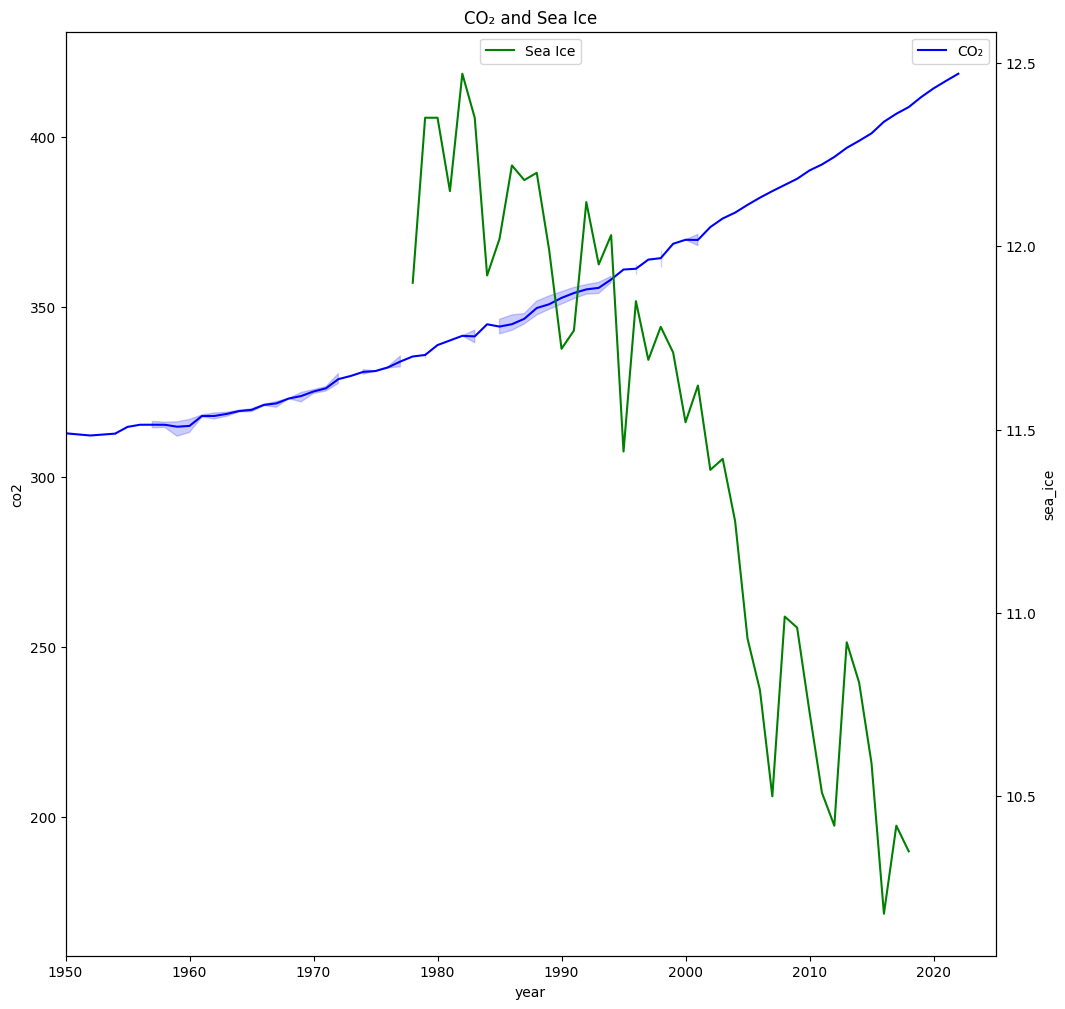

In [70]:
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.lineplot(x="year", y="co2", data=temp_CO2_present, color="b", ax=ax1, label="CO₂")
sns.lineplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice")
ax1.set_xlim(1950, 2025)
ax2.set_xlim(1950, 2025)
plt.title("CO₂ and Sea Ice")
plt.legend(loc='upper center')

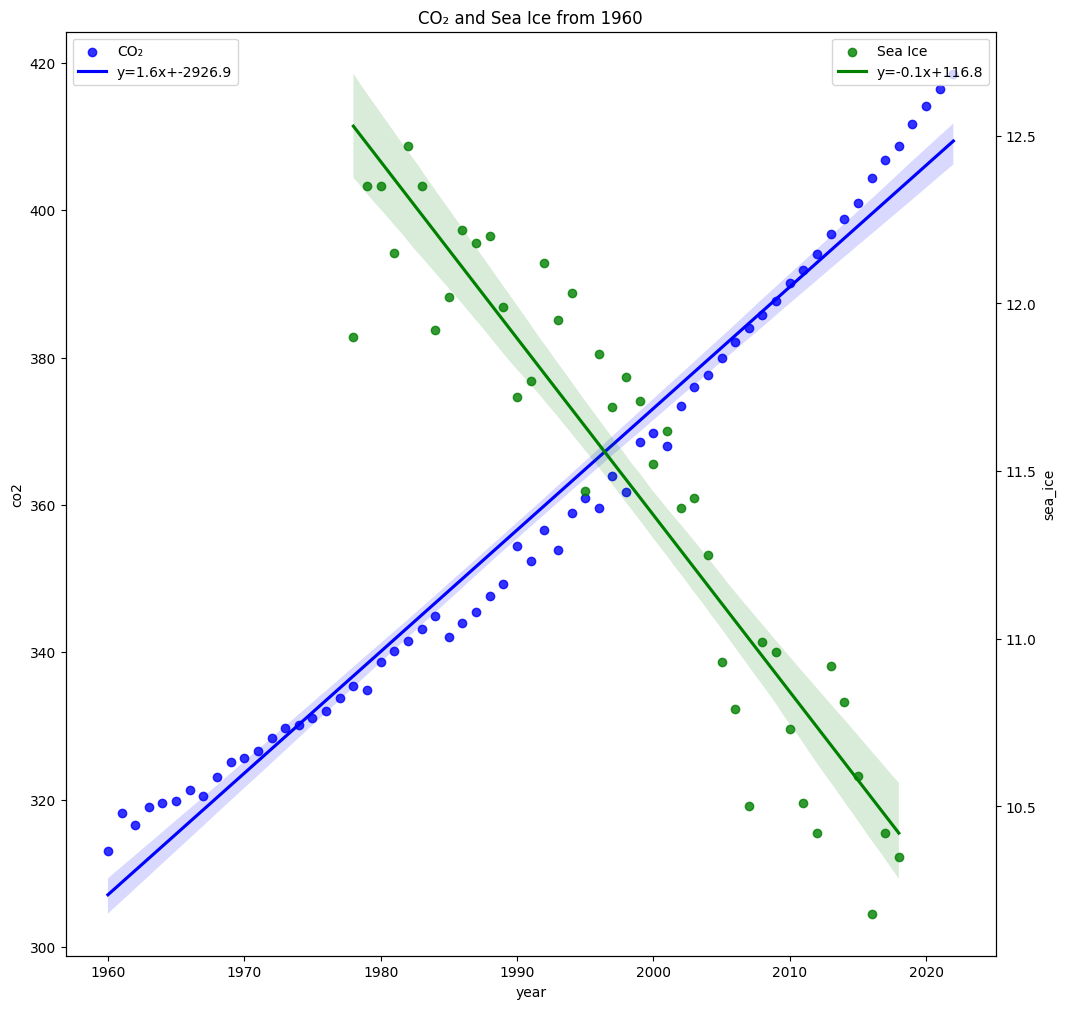

In [71]:
# get coeffs of linear fit
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(temp_CO2_from_1960['year'],temp_CO2_from_1960['co2'])

# to plot a regression plot of CO₂ and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()
sns.regplot(x="year", y="co2", data=temp_CO2_from_1960, color="b", ax=ax1, label="CO₂", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope2,intercept2)})
sns.regplot(x="year", y="sea_ice", data=df_seaice_mean, color="g", ax=ax2, label="Sea Ice", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope1,intercept1)})
plt.title("CO₂ and Sea Ice from 1960")
ax1.legend()
ax2.legend()

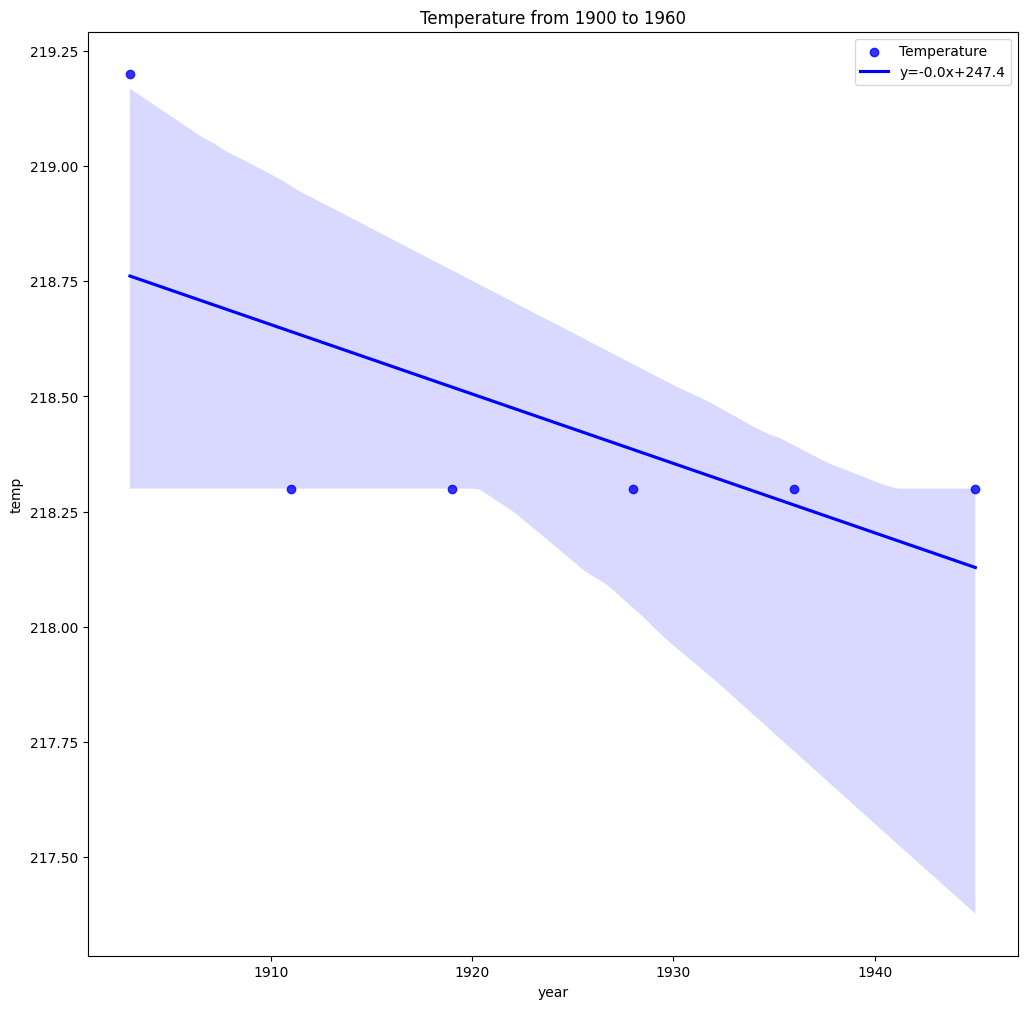

In [72]:
# to mask nan values so slope can be calculated
# https://stackoverflow.com/questions/13643363/linear-regression-of-arrays-containing-nans-in-python-numpy
mask = ~np.isnan(temp_CO2_from_1900to1960['year']) & ~np.isnan(temp_CO2_from_1900to1960['temp'])
slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(temp_CO2_from_1900to1960['year'][mask],temp_CO2_from_1900to1960['temp'][mask])

# to plot a regression plot of Temperature and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
sns.regplot(x="year", y="temp", data=temp_CO2_from_1900to1960, color="b", ax=ax1, label="Temperature", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope3,intercept3)})
plt.title("Temperature from 1900 to 1960")
ax1.legend()

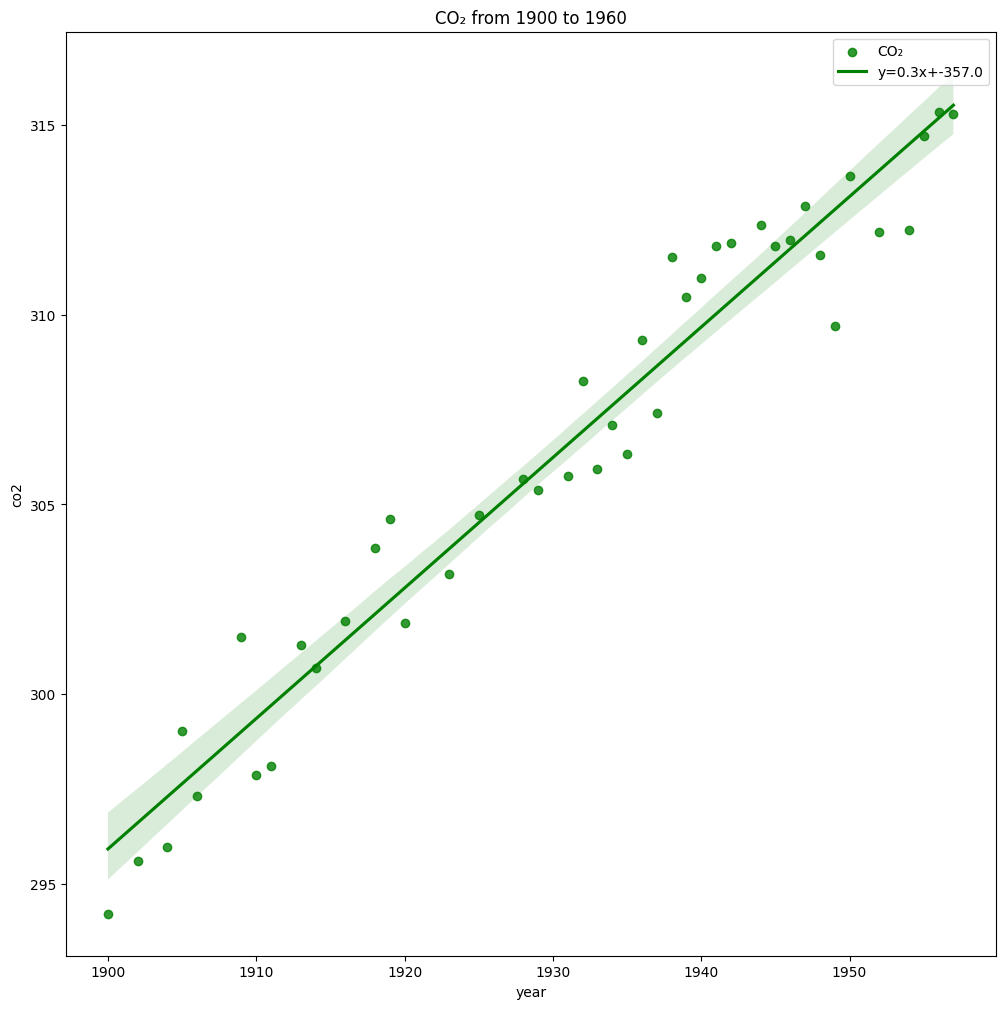

In [73]:
mask = ~np.isnan(temp_CO2_from_1900to1960['year']) & ~np.isnan(temp_CO2_from_1900to1960['co2'])
slope4, intercept4, r_value4, p_value4, std_err4 = stats.linregress(temp_CO2_from_1900to1960['year'][mask],temp_CO2_from_1900to1960['co2'][mask])

# to plot a regression plot of Temperature and Sea Ice with regression equation
fig, ax1 = plt.subplots(figsize=(12,12))
sns.regplot(x="year", y="co2", data=temp_CO2_from_1900to1960, color="g", ax=ax1, label="CO₂", line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope4,intercept4)})
plt.title("CO₂ from 1900 to 1960")
ax1.legend()

### Trends / Relationships between Variables

Trends and relationships between the variables in the dataframe were analysed using plots such as pairplots as displayed above, as well as correlation statistics generated using the .corr() function from pandas.

- There is a strong positive correlation between temperature and CO₂ as inidicated by the correlation value obtained of 0.93. Therefore, as temperature increases CO₂ also increases, and vice versa.
- Similarly, there is strong negative correlation between sea ice levels and both temperature and CO₂. A value of -0.95 was obtained, indicating that as temperature and CO₂ levels increase, sea ice levels will fall.
- This correlation is as expected. As has been widely studied and researched, temperature and CO₂ levels have accelerated in recent times, leading to unprecedented levels of global warming. This is turn has led to reduction in sea ice levels, as polar ice caps are melting at an alarming rate.
- Of course, a main topic of discussion is what is leading this pehenomenon. Much analysis has been performed in this area, with widespread discussion on whether CO₂ increases are leading to the global temperature increase or vice versa. Former US Vice-President Al Gore is famed for his work in this area, claiming that CO₂ increases are to blame for the global warming issues being experienced today. However, analysis performed on data gathered from ice cores for over 800k years seem to indicate that CO₂ increases actually lag behind temperature increases, causing some to come to the conclusion that CO₂ levels could not be blamed for earth's temperature increase.
- The answer,however, seems to lie somewhere in the middle. Increasing concentration of CO₂ in the atmosphere increases global temperature. Increasing global temperature also increases the concentration of CO₂ in the atmosphere.

https://skepticalscience.com/co2-lags-temperature-advanced.htm

### Lead/Lag/Frequency Analysis

Lead/lag analysis was performed on the dataset to determine which variable was responsible for the changes. The lead-lag effect is a phenomenon in which a change in one time series has a delayed effect on another time series.

In [74]:
# lagged correaltion to a target, testing various lags to see which lag gives the highest correlations
# i tested this for 500 years
# https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
lagged_correlation = pd.DataFrame.from_dict(
    {x: [combined_data['temp'].corr(combined_data[x].shift(-t)) for t in range(500)] for x in combined_data.columns})

lagged_correlation

,year,temp,co2,sea_ice,temp_ireland,rainfall_ireland
0,0.095402,1.000000,0.927946,-0.947311,-0.394235,0.101079
1,0.094585,0.999205,0.681863,-0.947942,-0.220202,0.314290
2,0.093762,0.999009,0.718057,-0.945066,0.458582,0.086189
3,0.092928,0.998953,0.709844,-0.954568,-0.140682,0.348489
4,0.092082,0.998794,0.708469,-0.941981,-0.282814,0.345247
...,...,...,...,...,...,...
495,-0.037892,0.132262,0.447426,-0.189772,0.130734,0.016422
496,-0.037891,0.128873,0.477492,-0.255080,-0.012634,-0.007162
497,-0.037890,0.134466,0.455801,-0.211468,-0.240902,0.044381
498,-0.038062,0.131831,0.455809,-0.325035,-0.121430,0.023848


In [75]:
# highest correlation for temperature and CO2
lagged_correlation.sort_values(by=['co2'], inplace=True, ascending=False)
lagged_correlation

,year,temp,co2,sea_ice,temp_ireland,rainfall_ireland
0,0.095402,1.000000,0.927946,-0.947311,-0.394235,0.101079
66,-0.006767,0.422698,0.739848,NaN,-0.029371,0.133461
64,-0.006663,0.466692,0.739459,NaN,0.181313,0.019019
65,-0.006718,0.432435,0.729038,NaN,0.192707,0.007985
71,-0.007024,0.394616,0.727374,NaN,0.529187,0.313277
...,...,...,...,...,...,...
461,-0.033315,0.134011,0.453915,-0.058934,-0.112252,-0.027307
492,-0.037501,0.133296,0.453320,0.034863,0.073904,0.040139
474,-0.035103,0.136737,0.450943,0.047242,-0.085516,0.014702
495,-0.037892,0.132262,0.447426,-0.189772,0.130734,0.016422


In [76]:
# highest correlation for temperature and sea ice
lagged_correlation.sort_values(by=['sea_ice'], inplace=True, ascending=True)
lagged_correlation

,year,temp,co2,sea_ice,temp_ireland,rainfall_ireland
224,-0.012459,0.190185,0.485530,-0.999990,-0.209918,-0.005946
225,-0.012445,0.185153,0.482584,-0.999129,-0.181107,-0.146060
229,-0.012373,0.179717,0.474853,-0.998119,-0.098599,-0.019861
227,-0.012409,0.181001,0.489791,-0.995088,0.226809,-0.149122
221,-0.012320,0.185009,0.488625,-0.982617,-0.451838,-0.031206
...,...,...,...,...,...,...
72,-0.007070,0.419040,0.700579,NaN,0.048376,0.127516
63,-0.000961,0.552373,0.657951,NaN,-0.655145,0.132963
62,0.003945,0.634871,0.633311,NaN,-0.479614,0.141164
61,0.003994,0.637367,0.631161,NaN,0.020385,-0.100763


From the data above, temperature and CO₂ seem to have little lag, in that the highest correlation occurs with a lag of zero. The next highest correlation value occurs with a lag of 66, indicating that CO₂ increases lag temperature increases by about 66 years.

Comparing temperature and sea ice, the highest negative correlation occurs with a lag of 224, indicating that temperature changes leads sea ice changes by about 224 years.

## Data Synthesis - Temperature Anomaly

Predict global temperature anomaly over next few decades (synthesise data) and compare to published climate models if atmospheric CO₂ trends continue.

In [77]:
import datetime as dt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

In [78]:
epica_tempanomaly = pd.read_csv('CSV Files\epica temp anomaly data.csv', encoding='ISO-8859-1')
epica_tempanomaly.year = epica_tempanomaly.year.round()
epica_tempanomaly = epica_tempanomaly[['year', 'temp_anomaly']]
epica_tempanomaly['year'] = 1950 - epica_tempanomaly['year']
epica_tempanomaly = epica_tempanomaly.astype({'year':'int'})

In [79]:
nasa_tempanomaly = pd.read_csv('CSV Files/nasa temp anomaly data.csv', encoding='ISO-8859-1', dtype={'year': int})
nasa_tempanomaly = nasa_tempanomaly[['year', 'temp_anomaly']]
#nasa_tempanomaly = nasa_tempanomaly.astype({'year':'int'})

In [80]:
combined_tempanomaly = epica_tempanomaly.merge(nasa_tempanomaly, how='outer')
combined_tempanomaly.sort_values(by=['year'], inplace=True, ascending=True);
#Pcombined_tempanomaly.to_csv('combined_tempanomaly.csv', index=False)

In [81]:
combined_tempanomaly.dtypes

year              int32
temp_anomaly    float64
dtype: object

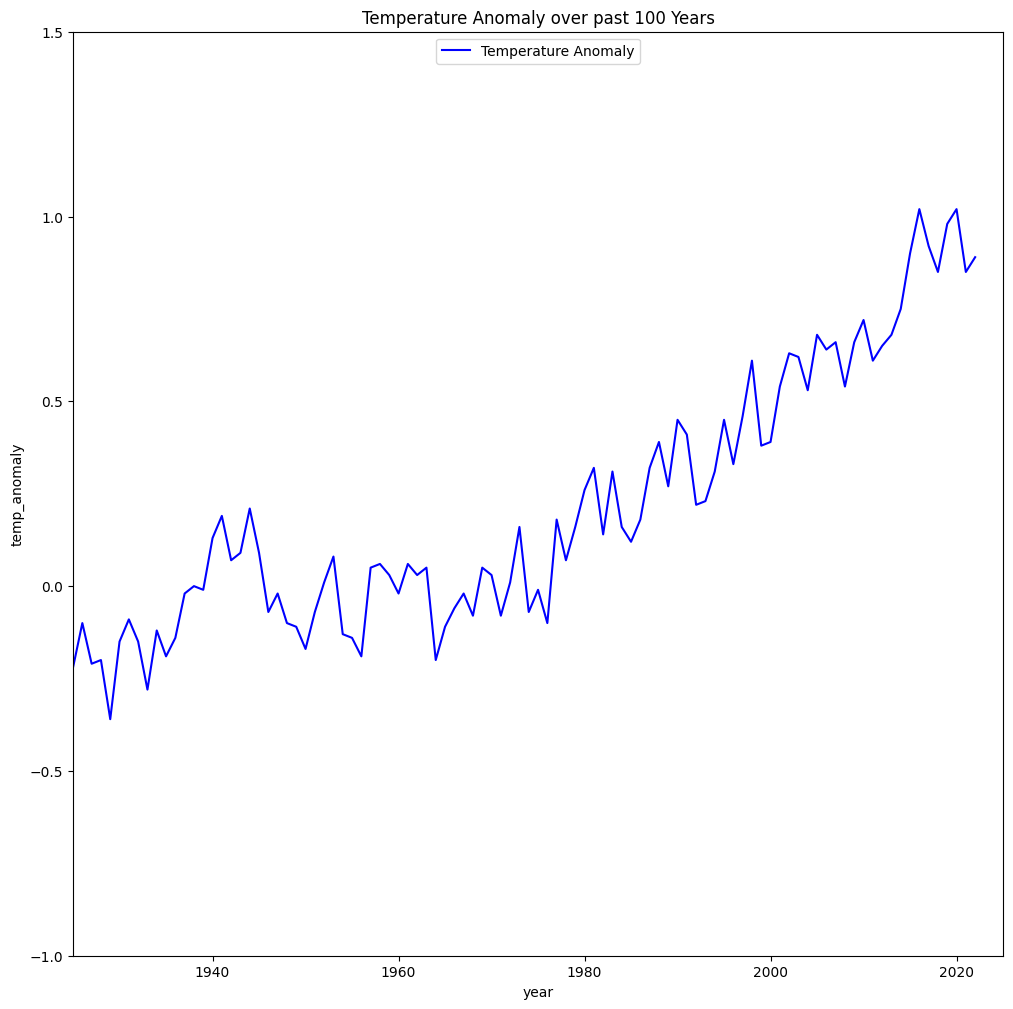

In [82]:
fig, ax = plt.subplots(figsize=(12,12))
sns.lineplot(x="year", y="temp_anomaly", data=combined_tempanomaly, color="b", ax=ax, label="Temperature Anomaly")
plt.title("Temperature Anomaly over past 100 Years")
ax.set_xlim(1925, 2025)
ax.set_ylim(-1, 1.5)
plt.legend(loc='upper center')

In [83]:
combined_tempanomaly = combined_tempanomaly.replace(np.nan, 0)
corr, p = pearsonr(combined_tempanomaly[combined_tempanomaly.year >= 1950].year, combined_tempanomaly[combined_tempanomaly.year >= 1950]['temp_anomaly'])
print('Pearson correlation of Year and Land Average Temperature: ' + str(corr))

Pearson correlation of Year and Land Average Temperature: 0.9055402529374557


In [84]:
lr = LinearRegression()

X = combined_tempanomaly[combined_tempanomaly['year'] >= 1950].year
y = combined_tempanomaly[combined_tempanomaly.year >= 1950]['temp_anomaly']

X = X.values.reshape(-1,1)

lr.fit(X, y)

y_pred = lr.predict(X)

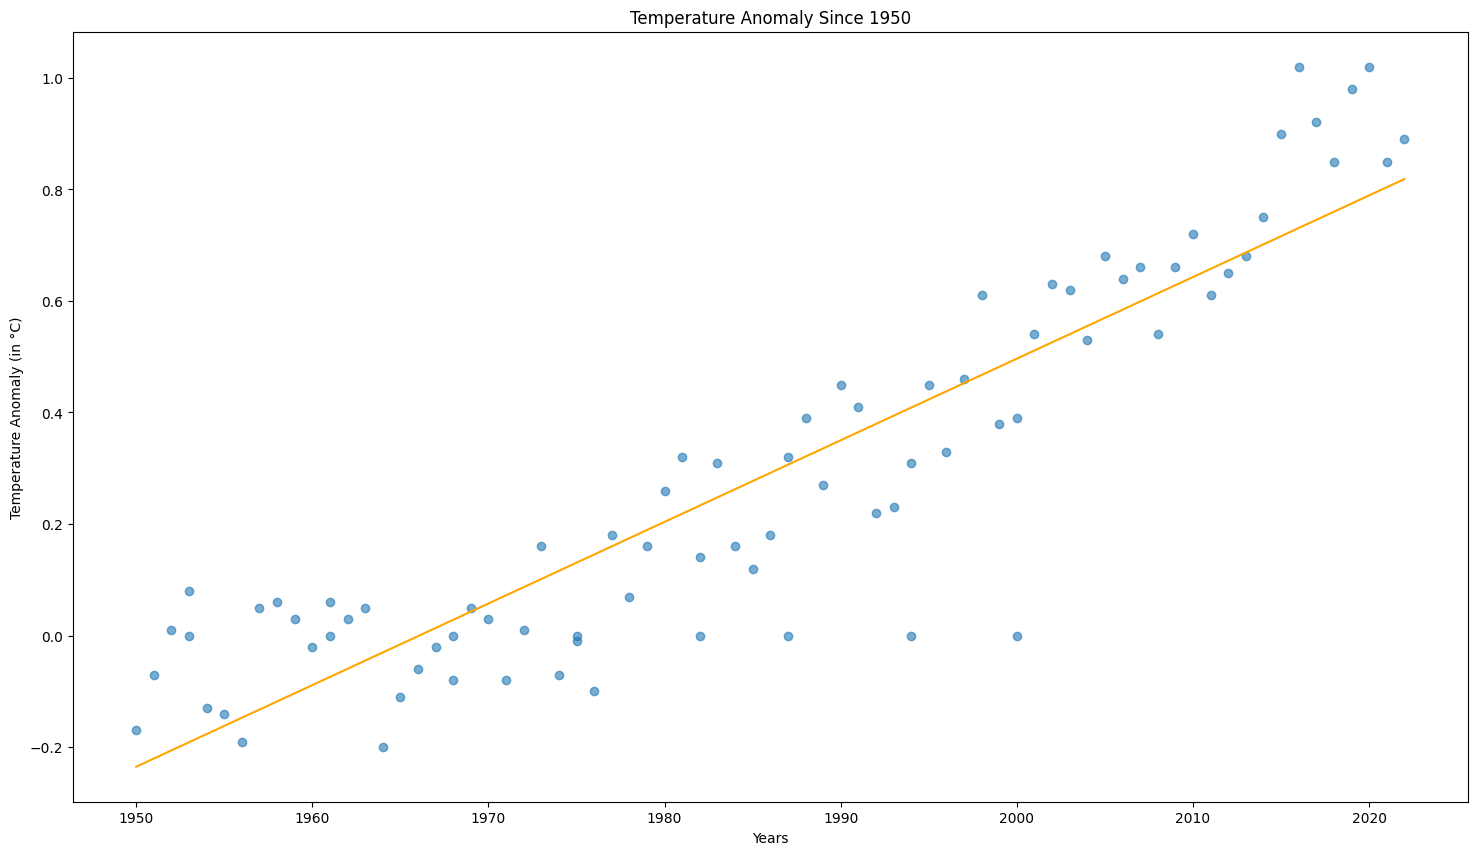

<Figure size 640x480 with 0 Axes>

In [85]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange")
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (in °C)')
plt.title("Temperature Anomaly Since 1950")
plt.show()
plt.clf()

In [86]:
print(lr.coef_) # yearly increase in temp anomaly
print(lr.coef_ * 10)    # 10 yearly increase in temp anomaly

[0.0146348]
[0.14634799]


In [87]:
predicted_data = lr.predict(np.array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
                           2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]).reshape(-1,1)) # temp anomaly prediction for 2021 to 2050

years_list = list(range(2021, 2051))

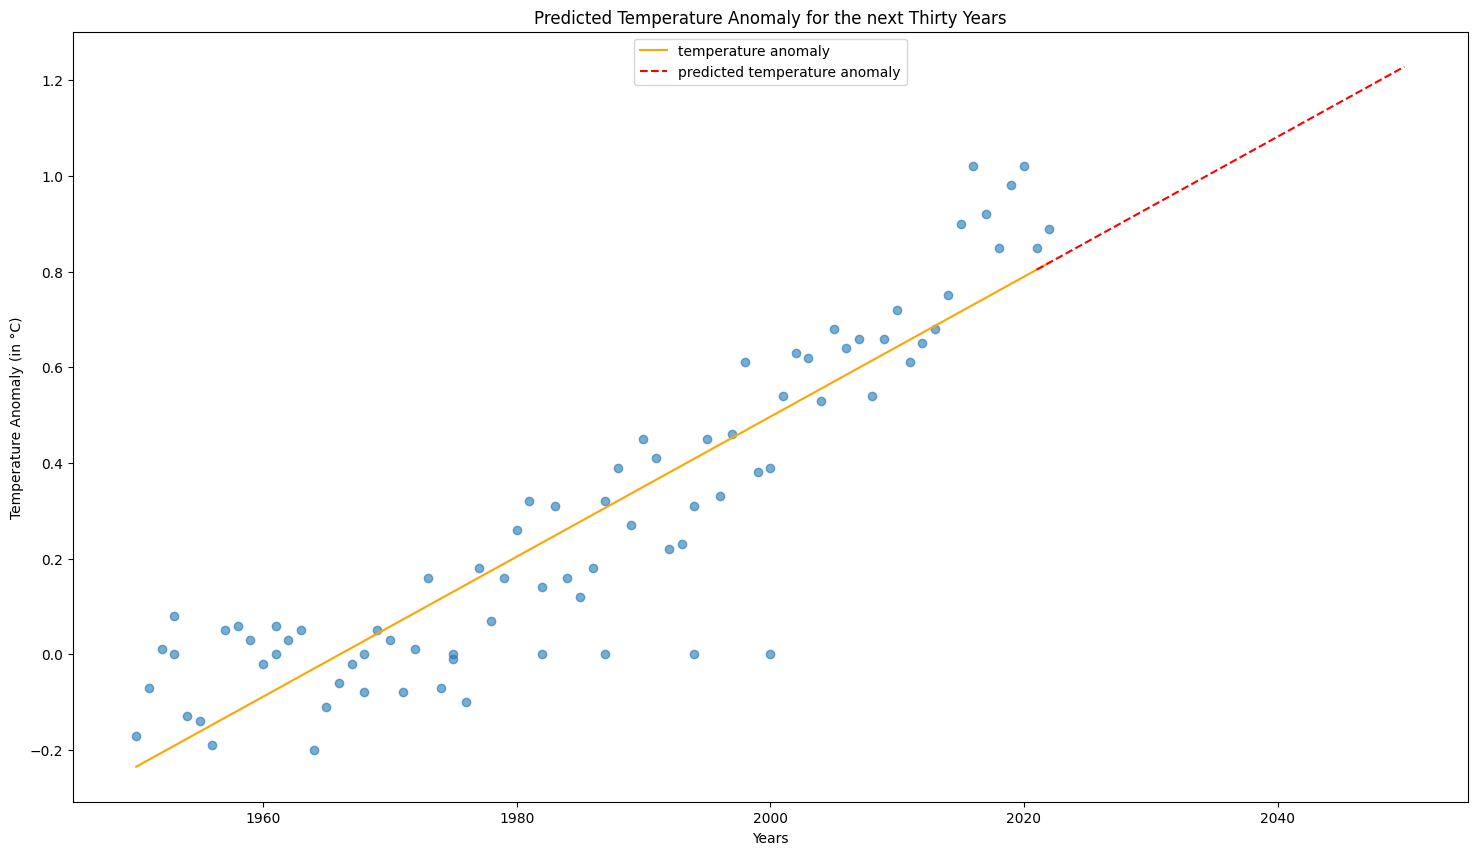

<Figure size 640x480 with 0 Axes>

In [88]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange", label="temperature anomaly")
plt.plot(years_list, predicted_data, color="red", linestyle="dashed", label="predicted temperature anomaly")
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (in °C)') 
plt.legend(loc='upper center')
plt.title("Predicted Temperature Anomaly for the next Thirty Years")
plt.show()
plt.clf()

In [89]:
predicted2 = combined_tempanomaly[combined_tempanomaly['year'] >= 1950]

X1 = predicted2['year'].values.reshape(-1,1)
Y1 = predicted2['temp_anomaly']
#split dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
#predict the test set results
y_pred_2 = regressor.predict(X_test)
y_pred_2

array([ 0.05029796,  0.12258977,  0.54188226, -0.06536894,  0.68646588,
        0.72984097,  0.15150649,  0.46959045,  0.44067373,  0.1081314 ,
        0.411757  ,  0.31054847,  0.38284028,  0.19488158,  0.71538261,
       -0.1954942 ,  0.49850718,  0.61417407,  0.29609011, -0.18103584,
        0.65754916, -0.13766075,  0.75875769,  0.81659114,  0.28163175])

In [90]:
predicted_data2 = regressor.predict(np.array([2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
                           2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050]).reshape(-1, 1))

years_list2 = list(range(2021, 2051))

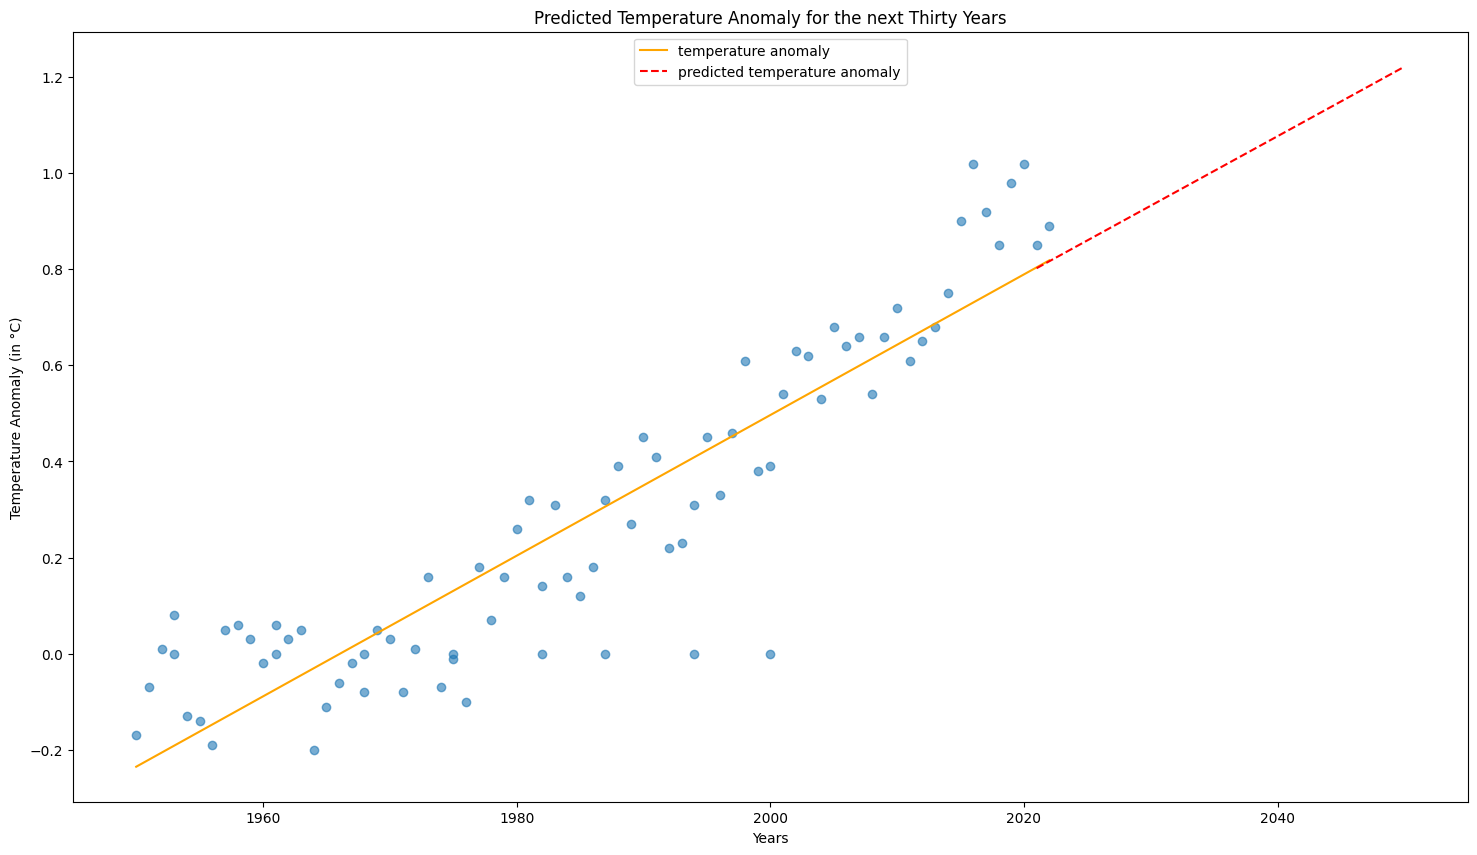

<Figure size 640x480 with 0 Axes>

In [91]:
plt.figure(figsize=(18,10))
plt.scatter(X, y, alpha=0.6)
plt.plot(X, y_pred, color="orange", label="temperature anomaly")
plt.plot(years_list2, predicted_data2, color="red", linestyle="dashed", label="predicted temperature anomaly")
plt.xlabel('Years')
plt.ylabel('Temperature Anomaly (in °C)') 
plt.legend(loc='upper center')
plt.title("Predicted Temperature Anomaly for the next Thirty Years")
plt.show()
plt.clf()

In [92]:
regressor.predict(np.array([2050]).reshape(-1,1)).round(2)

array([1.22])

A linear regression model was applied for predicting the average yearly temperature anomaly. The data from the year 1950 onwards was used to train and test the data. This is because this period of time represents the acceleration of temperature and CO₂ which has led to unprecendented global warming.

From the graph above, the predicted temperature anomaly for 2050 will exceed 1.2°C by the year 2050. This prediction is in line with published climate models for temperature anomaly if recent atmospheric CO₂ trends continue.

Lang et al (2023) predicted a temparture anomaly of 1.46°C in 2050 using a model with the same time period.

https://www.sciencedirect.com/science/article/pii/S2772662223000772

## Accelerated Warming Based on Very Latest Features

Global warming has hit unprecedented levels in the last 50 years. Temperature data collected from ice cores for over 800,000 years have shown temperature increase and decrease in a somewhat cyclical fashion. The dataset in this notebook clearly shows accelerated warming from the year 1950 onwards, with increases in CO₂ levels remaining in line with increased global temperatures.

A data set from NASA analysing global temperatures from 1880 to 2023 indicte the pace of warming clearly sped up around the year 1970. This acceleration has been attributed to a steep increase in greenhouse gas emissions, combined with efforts in many countries to reduce the amount of sun-reflecting pollution in the air. https://www.washingtonpost.com/climate-environment/2023/12/26/global-warming-accelerating-climate-change/

Added to this, from 1880 to 1969 while the planet warmed, it did so at a slow rate (approximately 0.04 degrees Celsius per decade). From 1970 onwards, this acceleration has risen to 0.19 degrees Celsius, over five times quicker than that seen in the previous nine decades. Again, this has widely been attributed to the increase in burning of fossil fuels, increase in air pollution from aerosols etc. Interestingly, the aerosol pollution actually led to a slower rate of warming, as the lightly coloured particles from the aerosols caused a temporary offset of the warming caused by the burning of fossil fuels. So, as government policies in much of the developed world focused on cleaning up the air pollution, aerosol usage dropped. This combined with the continued rise of greenhouse gas emissions have led to this accelerated warming that has occurred since the 1970s.

There has been commentary on whether a second acceleration has occurred in the 21st century, in particular in the past 15 years. However, there is much more uncertainty about if in fact this is the case.
Accelerationists, such as climate scientist, James E. Hansen and colleagues are predicting an increase in global warming by 50% in the next few decades, while traditionalists such as NASA scientist Mark Richardson has warned against making assumptions based on data from short timeframes as temperatures can change significantly. This thinking was supported by Texas A&M University scientist Andrew Dessler. Overall, it seems more data from a wider timeframe is required before scientists will make estimations on a second acceleration of global warming.

***

## References

***

End